In [65]:
%matplotlib notebook
import pandas as pd
import numpy as np
import math
import statistics
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder, normalize
import matplotlib.pyplot as plt
import seaborn as sn
import matplotlib
from mlxtend.plotting import plot_confusion_matrix
import warnings
from scipy.signal import savgol_filter, find_peaks, correlate
from sklearn.decomposition import PCA
import scipy.fftpack as FFT
from sklearn.utils import shuffle
import joblib
warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.figsize'] = [12,5]

## help functions

In [66]:
def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

def convert_to_datetime(x):
    dt = datetime.fromtimestamp(x // 1000000000)
    s = dt.strftime('%Y-%m-%d %H:%M:%S')
    s += '.' + str(int(x % 1000000000)).zfill(9)
    return s

def heatmap(cm, labels):
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)

    plt.show()
    
def preprocess(data, activity, drop_interval_begin = 3, drop_interval_end = 3):
    #convert nanoseconds to date 
    data['time'] = data['time'].apply(convert_to_datetime) 
    data['time'] = pd.to_datetime(data['time'])

#convert to same data type
    for i in range(1, 4): 
        data[column_names_org[i]] = data[column_names_org[i]].apply(convert_to_float)
    
#drop rows with NaN values 
    data.dropna(axis=0, how='any', inplace=True) #TODO: invullen met mean, mod of median / interpolatie

#drop duplicates 
    data.drop_duplicates(subset=None, keep='first', inplace = True)
    
    #drop first and last 3 sec
    indexFirst = data[ (data['time'].iloc[0]+ pd.to_timedelta(drop_interval_begin, unit='s')) > data['time'] ].index
    data.drop(indexFirst , inplace=True)
    indexLast = data[ (data['time'].iloc[-1]- pd.to_timedelta(drop_interval_end, unit='s')) < data['time'] ].index
    data.drop(indexLast , inplace=True)
    
    #add activity label
    data['activity'] = activity
    
    return data

#feature extraction
def get_mean_window(df):
    return df.mean()

def get_min_window(df):
    return df.min()

def get_max_window(df):
    return df.max()

def get_std_window(df):
    return df.std()

def get_med_window(df):
    return df.median()

#TODO: scipy integrate
#TODO: voor elke as apart??
#measure of activity level (m/s²)
def get_signal_magnitude_area(df):
        sum = 0
        for i in range(0, len(df)):
            sum += (abs(df['x'].iloc[i]) + abs(df['y'].iloc[i]) + abs(df['z'].iloc[i]))
        return sum /len(df)
    #result = integrate.quad(lambda t: df['x'].apply(lambda n : abs(n)) + df['y'].apply(lambda n : abs(n)) + df['z'].apply(lambda n : abs(n)), 0, len(df))

#TODO: voor elke as apart??
#degree of movement intensity (m/s²)
def get_signal_magnitude_vector(df):
    sum = 0
    for i in range(0, len(df)):
        sum += math.sqrt(df['x'].iloc[i] * df['x'].iloc[i] + df['y'].iloc[i] * df['y'].iloc[i] + df['z'].iloc[i] * df['z'].iloc[i])
    return sum

#average angle (radian) between accelerometer vector and x as (parallel with arm)
def get_tilt_angle(df):
    df_cos = pd.DataFrame(columns=["tilt_ang"])
    df_dot = df['x']
    for i in range(0, len(df)):
        s = pd.Series({"tilt_ang" : (df_dot.iloc[i])/(math.sqrt(df['x'].iloc[i]*df['x'].iloc[i] + df['y'].iloc[i]*df['y'].iloc[i] + df['z'].iloc[i]*df['z'].iloc[i]))})
        df_cos=df_cos.append(s, ignore_index=True)
    df_angle = np.arccos(df_cos)
    return df_angle.mean()['tilt_ang']

def get_power_spectral_density(df):
    df_psd = np.abs(df)**2
    return df_psd.sum()

#TODO: datatype is object en niet compex nr
def get_entropy(df):
    entropy = []
    pdf = df / df.sum()
    for i in range (1, len(pdf.columns)):
        entropy.append(np.complex(-np.nansum(pdf.iloc[:,i] * np.log2(pdf.iloc[:,i]))))
    return entropy

#generate windows with 50% overlap
def windows(df, time, overlap):
    start = df.iloc[0]
    while  (start + pd.to_timedelta(time, unit='s')) < df.iloc[-1]:
        yield start, (start + pd.to_timedelta(time, unit='s'))
        if overlap:
            start += pd.to_timedelta(time/2, unit='s')
        else:
            start += pd.to_timedelta(time, unit='s')
        
def feature_extraction_segmentation(data, window, overlap):
    column_names = ["x_mean", "y_mean", "z_mean", "x_min", "y_min", "z_min", "x_max", "y_max", "z_max",
                "x_std", "y_std", "z_std", "x_med", "y_med", "z_med", "activity"]
    df = pd.DataFrame(columns = column_names)

    for (start, end) in windows(data['time'], window, overlap):
        vw1 = data['time'] >= start
        vw2 = data['time'] < end
        mean = get_mean_window(data[vw1 & vw2])
        min = get_min_window(data[vw1 & vw2])
        max = get_max_window(data[vw1 & vw2])
        std = get_std_window(data[vw1 & vw2])
        med = get_med_window(data[vw1 & vw2])
        sma = get_signal_magnitude_area(data[vw1 & vw2])
        smv = get_signal_magnitude_vector(data[vw1 & vw2])
        tilt = get_tilt_angle(data[vw1 & vw2])
        #fourrier transform
        t_x = data[vw1 & vw2][['time','x']].set_index('time')
        t_y = data[vw1 & vw2][['time','y']].set_index('time')
        t_z = data[vw1 & vw2][['time', 'z']].set_index('time')

        df_f = pd.DataFrame(columns=['f', 'x_f', 'y_f', 'z_f'])

    #TODO: determine sampling rate (datapoints per second)
        sampling_rate = 18

        df_f['x_f'] = FFT.fft(t_x).ravel()
        df_f['y_f'] = FFT.fft(t_y).ravel()
        df_f['z_f'] = FFT.fft(t_z).ravel()
        df_f['f'] = FFT.fftfreq(len(df_f['x_f'])) * sampling_rate

        psd = get_power_spectral_density(df_f)
        #entropy = get_entropy(df_f)

        df = df.append(pd.Series({'x_mean': mean['x'], 'y_mean': mean['y'], 'z_mean': mean['z'], "x_min" : min['x'],
                              "y_min" : min['y'], "z_min" : min['z'], "x_max" : max['x'], "y_max" : max['y'], "z_max" : max['z'],
                              "x_std" : std['x'], "y_std" : std['y'], "z_std" : std['z'], "x_med" : med['x'], "y_med" : med['y'], "z_med" : med['z'],
                              "sma" : sma, "smv" : smv, "tilt" : tilt, "x_psd" : psd['x_f'], "y_psd" : psd['y_f'], "z_psd" : psd['z_f']
                              , "activity" : data['activity'].iloc[0]}), ignore_index=True) # "x_entropy" : entropy[0], "y_entropy" : entropy[1], "z_entropy" : entropy[2],
    return df


column_names_org = ['time', 'x', 'y', 'z']

# preprocessing

## jump_mixed: slow and fast jumping

In [67]:
jump_mixed = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\normal2.csv", sep=';', header=0, skipinitialspace=True)

jump_mixed.shape

(2730, 4)

In [68]:
jump_mixed = preprocess(jump_mixed, "normal")

jump_mixed.tail()

,time,x,y,z,activity
2514,1970-01-01 01:21:37.145528320,2.012364,9.985249,-16.204195,normal
2515,1970-01-01 01:21:37.164926976,1.706083,-5.216353,-16.089340,normal
2516,1970-01-01 01:21:37.184325632,-2.914458,-4.486542,-14.821143,normal
2517,1970-01-01 01:21:37.203462144,-5.053641,-9.008977,-9.745967,normal
2518,1970-01-01 01:21:37.224171520,-8.075776,-15.165709,-5.962914,normal


<IPython.core.display.Javascript object>


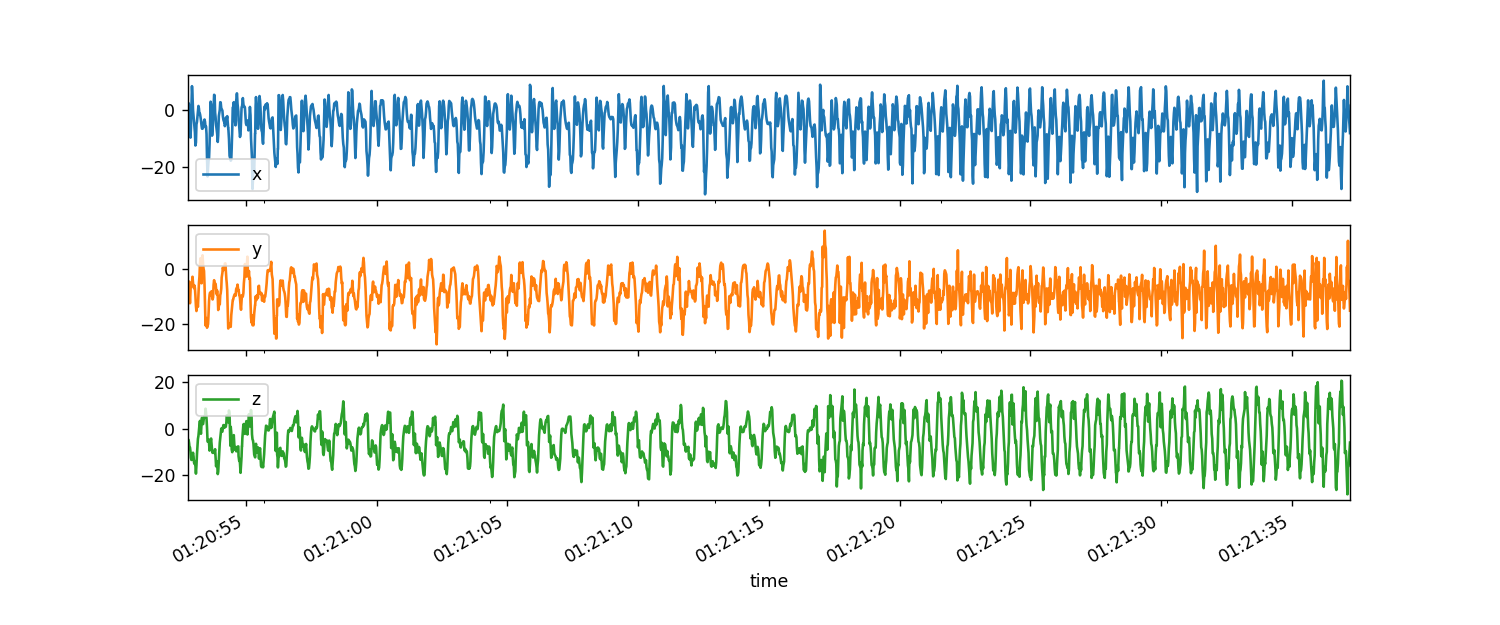

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000026AF61EE108>,
      dtype=object)

In [69]:
jump_mixed.plot(x='time', subplots=True)

# <font color='green' >PROEFPERSOON 1

## jump_fast

In [70]:
jump_fast_left_forward_1 = []
jump_fast_right_forward_1 = []
jump_fast_left_backwards_1 = []
jump_fast_right_backwards_1 = []

#### jump_fast_left_forward

In [71]:
jump_fast_left_forward1 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_fast\proefpersoon1\jump_fast_left_forward-tim.csv", sep=';', header=0, skipinitialspace=True)

jump_fast_left_forward1 = preprocess(jump_fast_left_forward1, "jump_fast", 3,5)

jump_fast_left_forward_1 = [jump_fast_left_forward1]

#### jump_fast_right_forward

In [72]:
jump_fast_right = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_fast\proefpersoon1\jump_fast_tim(meting2).csv", sep=';', header=0, skipinitialspace=True)

jump_fast_right = preprocess(jump_fast_right, "jump_fast")

jump_fast_right_forward_1 = [jump_fast_right]

#### jump_fast_left_backwards

In [73]:
jump_fast_left_backwards1 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_fast\proefpersoon1\jump_fast_left_backwards_tim1.csv", sep=';', header=0, skipinitialspace=True)
jump_fast_left_backwards2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_fast\proefpersoon1\jump_fast_left_backwards_tim2.csv", sep=';', header=0, skipinitialspace=True)
jump_fast_left_backwards3 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_fast\proefpersoon1\jump_fast_left_backwards_tim3.csv", sep=';', header=0, skipinitialspace=True)

jump_fast_left_backwards1 = preprocess(jump_fast_left_backwards1, "jump_fast")
jump_fast_left_backwards2 = preprocess(jump_fast_left_backwards2, "jump_fast")
jump_fast_left_backwards3 = preprocess(jump_fast_left_backwards3, "jump_fast")

jump_fast_left_backwards_1 = [jump_fast_left_backwards1, jump_fast_left_backwards2, jump_fast_left_backwards3]

#### jump_fast_right_backwards

In [74]:
jump_fast_right_backwards1 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_fast\proefpersoon1\jump_fast_right_backwards_tim.csv", sep=';', header=0, skipinitialspace=True)
jump_fast_right_backwards2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_fast\proefpersoon1\jump_fast_right_backwards_tim2.csv", sep=';', header=0, skipinitialspace=True)
jump_fast_right_backwards3 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_fast\proefpersoon1\jump_fast_right_backwards_tim3.csv", sep=';', header=0, skipinitialspace=True)

jump_fast_right_backwards1 = preprocess(jump_fast_right_backwards1, "jump_fast")
jump_fast_right_backwards2 = preprocess(jump_fast_right_backwards2, "jump_fast")
jump_fast_right_backwards3 = preprocess(jump_fast_right_backwards3, "jump_fast", 3, 4)

jump_fast_right_backwards_1 = [jump_fast_right_backwards1, jump_fast_right_backwards2, jump_fast_right_backwards3]

### SEGMENTATION

In [75]:
#segmentation + feature extraction
for i in range(0, len(jump_fast_left_forward_1)):
    jump_fast_left_forward_1[i] =  feature_extraction_segmentation(jump_fast_left_forward_1[i],1, True)

for i in range(0, len(jump_fast_right_forward_1)):
    jump_fast_right_forward_1[i] =  feature_extraction_segmentation(jump_fast_right_forward_1[i],1, True)
    
for i in range(0, len(jump_fast_left_backwards_1)):
    jump_fast_left_backwards_1[i] =  feature_extraction_segmentation(jump_fast_left_backwards_1[i],1, True)
    
for i in range(0, len(jump_fast_right_backwards_1)):
    jump_fast_right_backwards_1[i] =  feature_extraction_segmentation(jump_fast_right_backwards_1[i],1, True)

In [76]:
jump_fast_right_backwards_1 = pd.concat(jump_fast_right_backwards_1, ignore_index=True)
jump_fast_right_backwards_1.shape

(69, 22)

In [77]:
jump_fast_left_forward_1 = pd.concat(jump_fast_left_forward_1, ignore_index=True)
jump_fast_left_forward_1.shape

(30, 22)

In [78]:
jump_fast_right_forward_1 = pd.concat(jump_fast_right_forward_1, ignore_index=True)
jump_fast_right_forward_1.shape

(57, 22)

In [79]:
jump_fast_left_backwards_1 = pd.concat(jump_fast_left_backwards_1, ignore_index=True)
jump_fast_left_backwards_1.shape

(83, 22)

## jump_slow

In [80]:
jump_slow_left_forward_1 = []
jump_slow_right_forward_1 = []
jump_slow_left_backwards_1 = []
jump_slow_right_backwards_1 = []

#### jump_slow_left_forward

In [81]:
jump_slow3 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow\proefpersoon1\jump_slow_left_forward_tim.csv", sep=';', header=0, skipinitialspace=True)

jump_slow3 = preprocess(jump_slow3, "jump_slow")

jump_slow_left_forward_1 = [jump_slow3]

#### jump_slow_right_forward

In [82]:
jump_slow_rigth = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow\proefpersoon1\jump_slow_tim.csv", sep=';', header=0, skipinitialspace=True)

jump_slow_rigth = preprocess(jump_slow_rigth, "jump_slow")

jump_slow_right_forward_1 = [jump_slow_rigth]

#### jump_slow_left_backwards

In [83]:
jump_slow_left_backwards1 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow\proefpersoon1\jump_slow_left_backwards_tim1.csv", sep=';', header=0, skipinitialspace=True)
jump_slow_left_backwards2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow\proefpersoon1\jump_slow_left_backwards_tim2.csv", sep=';', header=0, skipinitialspace=True)
jump_slow_left_backwards3 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow\proefpersoon1\jump_slow_left_backwards_tim3.csv", sep=';', header=0, skipinitialspace=True)

jump_slow_left_backwards1 = preprocess(jump_slow_left_backwards1, "jump_slow", 3, 5)
jump_slow_left_backwards2 = preprocess(jump_slow_left_backwards2, "jump_slow")
jump_slow_left_backwards3 = preprocess(jump_slow_left_backwards3, "jump_slow")

jump_slow_left_backwards_1 = [jump_slow_left_backwards1, jump_slow_left_backwards2, jump_slow_left_backwards3]

<IPython.core.display.Javascript object>


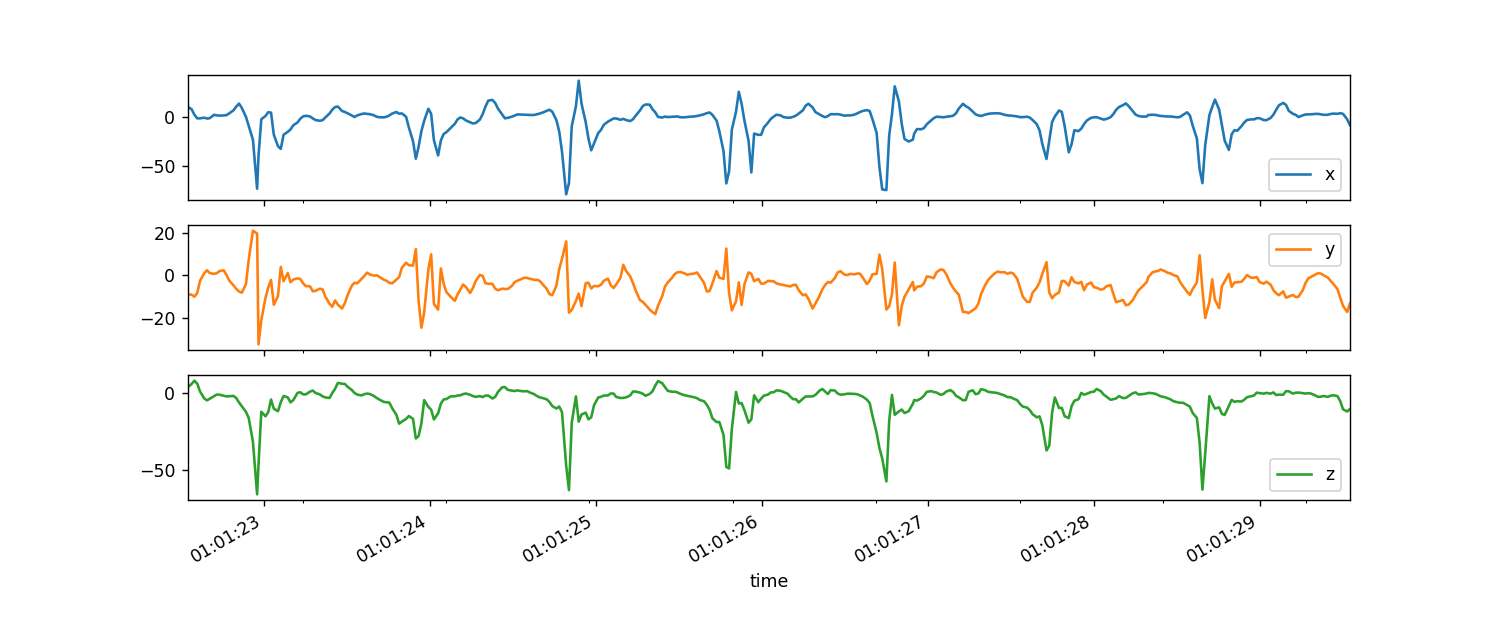

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000026AF81CEC48>,
      dtype=object)

In [84]:
jump_slow_left_backwards3.plot(x='time', subplots=True)

#### jump_slow_right_backwards

In [85]:
jump_slow_right_backwards1 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow\proefpersoon1\jump_slow_right_backwards_tim.csv", sep=';', header=0, skipinitialspace=True)
jump_slow_right_backwards2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow\proefpersoon1\jump_slow_right_backwards_tim1.csv", sep=';', header=0, skipinitialspace=True)

jump_slow_right_backwards1 = preprocess(jump_slow_right_backwards1, "jump_slow")
jump_slow_right_backwards2 = preprocess(jump_slow_right_backwards2, "jump_slow")

jump_slow_right_backwards_1 = [jump_slow_right_backwards1, jump_slow_right_backwards2]

### SEGMENTATION

In [86]:
#segmentation + feature extraction
for i in range(0, len(jump_slow_left_forward_1)):
    jump_slow_left_forward_1[i] =  feature_extraction_segmentation(jump_slow_left_forward_1[i],1, True)
    
for i in range(0, len(jump_slow_right_forward_1)): 
    jump_slow_right_forward_1[i] =  feature_extraction_segmentation(jump_slow_right_forward_1[i],1, True)
    
for i in range(0, len(jump_slow_left_backwards_1)):
    jump_slow_left_backwards_1[i] =  feature_extraction_segmentation(jump_slow_left_backwards_1[i],1, True)

for i in range(0, len(jump_slow_right_backwards_1)):
    jump_slow_right_backwards_1[i] =  feature_extraction_segmentation(jump_slow_right_backwards_1[i],1, True)


In [87]:
jump_slow_left_backwards_1 = pd.concat(jump_slow_left_backwards_1, ignore_index=True)
jump_slow_left_backwards_1.shape

(80, 22)

In [88]:
jump_slow_right_backwards_1 = pd.concat(jump_slow_right_backwards_1, ignore_index=True)
jump_slow_right_backwards_1.shape

(111, 22)

In [89]:
jump_slow_left_forward_1 = pd.concat(jump_slow_left_forward_1, ignore_index=True)
jump_slow_left_forward_1.shape

(33, 22)

In [90]:
jump_slow_right_forward_1 = pd.concat(jump_slow_right_forward_1, ignore_index=True)
jump_slow_right_forward_1.shape

(70, 22)

## side swing

In [91]:
side_swing_left_forward_1 = []
side_swing_right_forward_1 = []
side_swing_left_backwards_1 = []
side_swing_right_backwards_1 = []

#### side_swing_left_forward

In [92]:
side_swing4 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\side_swing\proefpersoon1\side_swing_left_forward-tim.csv", sep=';', header=0, skipinitialspace=True)

side_swing4 = preprocess(side_swing4, "side_swing", 3, 4)

side_swing_left_forward_1 = [ side_swing4]

#### side_swing_right_forward

In [93]:
side_swing_rigth = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\side_swing\proefpersoon1\side_swing_tim.csv", sep=';', header=0, skipinitialspace=True)

side_swing_rigth = preprocess(side_swing_rigth, "side_swing")

side_swing_right_forward_1 = [side_swing_rigth]

#### side_swing_left_backwards

#### side_swing_right_backwards

In [94]:
#segmentation + feature extraction
for i in range(0, len(side_swing_left_forward_1)):
    side_swing_left_forward_1[i] =  feature_extraction_segmentation(side_swing_left_forward_1[i],1, True)

for i in range(0, len(side_swing_right_forward_1)):
    side_swing_right_forward_1[i] =  feature_extraction_segmentation(side_swing_right_forward_1[i],1, True)
    
for i in range(0, len(side_swing_left_backwards_1)):
    side_swing_left_backwards_1[i] =  feature_extraction_segmentation(side_swing_left_backwards_1[i],1, True)

for i in range(0, len(side_swing_right_backwards_1)):
    side_swing_right_backwards_1[i] =  feature_extraction_segmentation(side_swing_right_backwards_1[i],1, True)

In [95]:
#side_swing_right_backwards  = pd.concat(side_swing_right_backwards, ignore_index=True)
side_swing_right_backwards_1 = pd.DataFrame()

In [96]:
side_swing_left_forward_1  = pd.concat(side_swing_left_forward_1, ignore_index=True)
side_swing_left_forward_1.shape

(104, 22)

In [97]:
side_swing_right_forward_1  = pd.concat(side_swing_right_forward_1, ignore_index=True)
side_swing_right_forward_1.shape

(101, 22)

In [98]:
#side_swing_left_backwards_1  = pd.concat(side_swing_left_backwards_1, ignore_index=True)
side_swing_left_backwards_1 = pd.DataFrame()
side_swing_left_backwards_1.shape

(0, 0)

## cross over

In [99]:
cross_over_left_forward_1 = []
cross_over_left_backwards_1 = []
cross_over_right_forward_1 = []
cross_over_right_backwards_1 = []

#### cross_over_left_forward

#### cross_over_left_backwards

#### cross_over_right_forward

#### cross_over_right_backwards

In [100]:
#segmentation + feature extraction
for i in range(0, len(cross_over_left_forward_1)):
    cross_over_left_forward_1[i] =  feature_extraction_segmentation(cross_over_left_forward_1[i],1, True)

for i in range(0, len(cross_over_left_backwards_1)):
    cross_over_left_backwards_1[i] =  feature_extraction_segmentation(cross_over_left_backwards_1[i],1, True)

for i in range(0, len(cross_over_right_forward_1)):
    cross_over_right_forward_1[i] =  feature_extraction_segmentation(cross_over_right_forward_1[i],1, True)

for i in range(0, len(cross_over_right_backwards_1)):
    cross_over_right_backwards_1[i] =  feature_extraction_segmentation(cross_over_right_backwards_1[i],1, True)

In [101]:
#cross_over_right_backwards = pd.concat(cross_over_right_backwards, ignore_index=True)
cross_over_right_backwards_1 = pd.DataFrame()

In [102]:
#cross_over_right_forward = pd.concat(cross_over_right_forward, ignore_index=True)
cross_over_right_forward_1 = pd.DataFrame()

In [103]:
#cross_over_left_forward_1 = pd.concat(cross_over_left_forward_1, ignore_index=True)
cross_over_left_forward_1 = pd.DataFrame()
cross_over_left_forward_1.shape

(0, 0)

In [104]:
#cross_over_left_backwards_1 = pd.concat(cross_over_left_backwards_1, ignore_index=True)
cross_over_left_backwards_1 = pd.DataFrame()
cross_over_left_backwards_1.shape

(0, 0)

## forward 180

OPM: window data van 2 verschillende forward 180s => niet realistisch

In [105]:
forward_180_left_forward_1 = []
forward_180_right_forward_1 = []
forward_180_left_backwards_1 = []
forward_180_right_backwards_1= []

#### forward_180_left_forward

<font color='red'>TODO</font>: in preprocessing uitknippen!!!!!!!! (forward_180_2)

In [106]:
forward_180_2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_left_forward_tim.csv", sep=';', header=0, skipinitialspace=True)

forward_180_2 = preprocess(forward_180_2, "forward_180")

forward_180_left_forward_1 = [forward_180_2]

#### forward_180_right_forward

In [107]:
forward_180_right_forward1 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_tim.csv", sep=';', header=0, skipinitialspace=True)

forward_180_right_forward1 = preprocess(forward_180_right_forward1, "forward_180")

forward_180_right_forward_1 = [forward_180_right_forward1]

#### forward_180_left_backwards

#### forward_180_right_backwards

### SEGMENTATION

In [108]:
#segmentation + feature extraction
for i in range(0, len(forward_180_left_forward_1)):
    forward_180_left_forward_1[i] =  feature_extraction_segmentation(forward_180_left_forward_1[i],1, True)

for i in range(0, len(forward_180_right_forward_1)):
    forward_180_right_forward_1[i] =  feature_extraction_segmentation(forward_180_right_forward_1[i],1, True)

for i in range(0, len(forward_180_left_backwards_1)):
    forward_180_left_backwards_1[i] =  feature_extraction_segmentation(forward_180_left_backwards_1[i],1, True)
    
for i in range(0, len(forward_180_right_backwards_1)):
    forward_180_right_backwards_1[i] =  feature_extraction_segmentation(forward_180_right_backwards_1[i],1, True)

In [109]:
forward_180_left_forward_1 = pd.concat(forward_180_left_forward_1, ignore_index=True)
forward_180_left_forward_1.shape

(88, 22)

In [110]:
forward_180_right_forward_1 = pd.concat(forward_180_right_forward_1, ignore_index=True)
forward_180_right_forward_1.shape

(79, 22)

In [111]:
#forward_180_left_backwards = pd.concat(forward_180_left_backwards, ignore_index=True)
forward_180_left_backwards_1 = pd.DataFrame()

In [112]:
#forward_180_right_backwards = pd.concat(forward_180_right_backwards, ignore_index=True)
forward_180_right_backwards_1 = pd.DataFrame()

## shuffle - balance data

#### left - forward

In [113]:
shape_left_forward_1 = np.min([jump_fast_left_forward_1.shape[0], jump_slow_left_forward_1.shape[0], side_swing_left_forward_1.shape[0], cross_over_left_forward_1.shape[0], forward_180_left_forward_1.shape[0]])
print(jump_fast_left_forward_1.shape[0], jump_slow_left_forward_1.shape[0], side_swing_left_forward_1.shape[0], cross_over_left_forward_1.shape[0], forward_180_left_forward_1.shape[0])
jump_fast_left_forward_1 = shuffle(jump_fast_left_forward_1).head(shape_left_forward_1).copy()
jump_slow_left_forward_1 = shuffle(jump_slow_left_forward_1).head(shape_left_forward_1).copy()
side_swing_left_forward_1 = shuffle(side_swing_left_forward_1).head(shape_left_forward_1).copy()
cross_over_left_forward_1 = shuffle(cross_over_left_forward_1).head(shape_left_forward_1).copy()
forward_180_left_forward_1 = shuffle(forward_180_left_forward_1).head(shape_left_forward_1).copy()
shape_left_forward_1

30 33 104 0 88


0

#### left - backwards

In [114]:
shape_left_backwards_1 = np.min([jump_fast_left_backwards_1.shape[0], jump_slow_left_backwards_1.shape[0], side_swing_left_backwards_1.shape[0], cross_over_left_backwards_1.shape[0], forward_180_left_backwards_1.shape[0]])
print(jump_fast_left_backwards_1.shape[0], jump_slow_left_backwards_1.shape[0], side_swing_left_backwards_1.shape[0], cross_over_left_backwards_1.shape[0], forward_180_left_backwards_1.shape[0])
jump_fast_left_backwards_1 = shuffle(jump_fast_left_backwards_1).head(shape_left_backwards_1).copy()
jump_slow_left_backwards_1 = shuffle(jump_slow_left_backwards_1).head(shape_left_backwards_1).copy()
side_swing_left_backwards_1 = shuffle(side_swing_left_backwards_1).head(shape_left_backwards_1).copy()
cross_over_left_backwards_1 = shuffle(cross_over_left_backwards_1).head(shape_left_backwards_1).copy()
forward_180_left_backwards_1 = shuffle(forward_180_left_backwards_1).head(shape_left_backwards_1).copy()
shape_left_backwards_1

83 80 0 0 0


0

#### right - forward

In [115]:
shape_right_forward_1 = np.min([jump_fast_right_forward_1.shape[0], jump_slow_right_forward_1.shape[0], side_swing_right_forward_1.shape[0], cross_over_right_forward_1.shape[0], forward_180_right_forward_1.shape[0]])
print(jump_fast_right_forward_1.shape, jump_slow_right_forward_1.shape, side_swing_right_forward_1.shape, cross_over_right_forward_1.shape, forward_180_right_forward_1.shape)
jump_fast_right_forward_1 = shuffle(jump_fast_right_forward_1).head(shape_right_forward_1).copy()
jump_slow_right_forward_1 = shuffle(jump_slow_right_forward_1).head(shape_right_forward_1).copy()
side_swing_right_forward_1 = shuffle(side_swing_right_forward_1).head(shape_right_forward_1).copy()
cross_over_right_forward_1 = shuffle(cross_over_right_forward_1).head(shape_right_forward_1).copy()
forward_180_right_forward_1 = shuffle(forward_180_right_forward_1).head(shape_right_forward_1).copy()
shape_right_forward_1

(57, 22) (70, 22) (101, 22) (0, 0) (79, 22)


0

#### right - backwards

In [116]:
shape_right_backwards_1 = np.min([jump_fast_right_backwards_1.shape[0], jump_slow_right_backwards_1.shape[0], side_swing_right_backwards_1.shape[0], cross_over_right_backwards_1.shape[0], forward_180_right_backwards_1.shape[0]])
print(jump_fast_right_backwards_1.shape[0], jump_slow_right_backwards_1.shape[0], side_swing_right_backwards_1.shape[0], cross_over_right_backwards_1.shape[0], forward_180_right_backwards_1.shape[0])
jump_fast_right_backwards_1 = shuffle(jump_fast_right_backwards_1).head(shape_right_backwards_1).copy()
jump_slow_right_backwards_1 = shuffle(jump_slow_right_backwards_1).head(shape_right_backwards_1).copy()
side_swing_right_backwards_1 = shuffle(side_swing_right_backwards_1).head(shape_right_backwards_1).copy()
cross_over_right_backwards_1 = shuffle(cross_over_right_backwards_1).head(shape_right_backwards_1).copy()
forward_180_right_backwards_1 = shuffle(forward_180_right_backwards_1).head(shape_right_backwards_1).copy()
shape_right_backwards_1

69 111 0 0 0


0

In [117]:
shape_1 = np.min([shape_right_backwards_1, shape_right_forward_1, shape_left_backwards_1, shape_left_forward_1])
shape_1

0

# <font color='green' >PROEFPERSOON 2

## jump_fast

In [118]:
jump_fast_left_forward_2 = []
jump_fast_right_forward_2 = []
jump_fast_left_backwards_2 = []
jump_fast_right_backwards_2 = []

#### jump_fast_left_forward

In [119]:
jump_fast = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_fast\proefpersoon2\jump_fast.csv", sep=';', header=0, skipinitialspace=True)
jump_fast2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_fast\proefpersoon2\jump_fast (meting2).csv", sep=';', header=0, skipinitialspace=True)

jump_fast = preprocess(jump_fast, "jump_fast")
jump_fast2 = preprocess(jump_fast2, "jump_fast")

jump_fast_left_forward_2 = [jump_fast, jump_fast2]

#### jump_fast_right_forward

In [120]:
jump_fast_right_forward1 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_fast\proefpersoon2\jump_fast_right_forward1.csv", sep=';', header=0, skipinitialspace=True)
jump_fast_right_forward2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_fast\proefpersoon2\jump_fast_right_forward2.csv", sep=';', header=0, skipinitialspace=True)

jump_fast_right_forward1 = preprocess(jump_fast_right_forward1, "jump_fast")
jump_fast_right_forward2 = preprocess(jump_fast_right_forward2, "jump_fast", 3, 5)

jump_fast_right_forward_2 = [jump_fast_right_forward1, jump_fast_right_forward2]

#### jump_fast_left_backwards

In [121]:
jump_fast_left_backwards1 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_fast\proefpersoon2\jump_fast_backwards.csv", sep=';', header=0, skipinitialspace=True)

jump_fast_left_backwards1 = preprocess(jump_fast_left_backwards1, "jump_fast")

jump_fast_left_backwards_2 = [jump_fast_left_backwards1]

#### jump_fast_right_backwards

In [122]:
jump_fast_right_backwards1 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_fast\proefpersoon2\jump_fast_right_backwards1.csv", sep=';', header=0, skipinitialspace=True)
jump_fast_right_backwards2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_fast\proefpersoon2\jump_fast_right_backwards2.csv", sep=';', header=0, skipinitialspace=True)

jump_fast_right_backwards1 = preprocess(jump_fast_right_backwards1, "jump_fast")
jump_fast_right_backwards2 = preprocess(jump_fast_right_backwards2, "jump_fast")

jump_fast_right_backwards_2 = [jump_fast_right_backwards1, jump_fast_right_backwards2]

### SEGMENTATION

In [123]:
#segmentation + feature extraction
for i in range(0, len(jump_fast_left_forward_2)):
    jump_fast_left_forward_2[i] =  feature_extraction_segmentation(jump_fast_left_forward_2[i],1, True)

for i in range(0, len(jump_fast_right_forward_2)):
    jump_fast_right_forward_2[i] =  feature_extraction_segmentation(jump_fast_right_forward_2[i],1, True)
    
for i in range(0, len(jump_fast_left_backwards_2)):
    jump_fast_left_backwards_2[i] =  feature_extraction_segmentation(jump_fast_left_backwards_2[i],1, True)
    
for i in range(0, len(jump_fast_right_backwards_2)):
    jump_fast_right_backwards_2[i] =  feature_extraction_segmentation(jump_fast_right_backwards_2[i],1, True)

In [124]:
jump_fast_right_backwards_2 = pd.concat(jump_fast_right_backwards_2, ignore_index=True)
jump_fast_right_backwards_2.shape

(133, 22)

In [125]:
jump_fast_left_forward_2 = pd.concat(jump_fast_left_forward_2, ignore_index=True)
jump_fast_left_forward_2.shape

(151, 22)

In [126]:
jump_fast_right_forward_2 = pd.concat(jump_fast_right_forward_2, ignore_index=True)
jump_fast_right_forward_2.shape

(163, 22)

In [127]:
jump_fast_left_backwards_2 = pd.concat(jump_fast_left_backwards_2, ignore_index=True)
jump_fast_left_backwards_2.shape

(60, 22)

## jump_slow

In [128]:
jump_slow_left_forward_2 = []
jump_slow_right_forward_2 = []
jump_slow_left_backwards_2 = []
jump_slow_right_backwards_2 = []

#### jump_slow_left_forward

In [129]:
jump_slow = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow\proefpersoon2\jump_slow.csv", sep=';', header=0, skipinitialspace=True)
jump_slow2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow\proefpersoon2\jump_slow1 (meting2).csv", sep=';', header=0, skipinitialspace=True)

jump_slow = preprocess(jump_slow, "jump_slow")
jump_slow2 = preprocess(jump_slow2, "jump_slow")

jump_slow_left_forward_2 = [jump_slow, jump_slow2]

#### jump_slow_right_forward

In [130]:
jump_slow_rigth = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow\proefpersoon2\jump_slow_right1.csv", sep=';', header=0, skipinitialspace=True)
jump_slow_rigth2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow\proefpersoon2\jump_slow_right2.csv", sep=';', header=0, skipinitialspace=True)
jump_slow_rigth3 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow\proefpersoon2\jumpslow_right_forward.csv", sep=';', header=0, skipinitialspace=True)
jump_slow_rigth4 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow\proefpersoon2\jumpslow_right_forward2.csv", sep=';', header=0, skipinitialspace=True)

jump_slow_rigth = preprocess(jump_slow_rigth, "jump_slow")
jump_slow_rigth2 = preprocess(jump_slow_rigth2, "jump_slow")
jump_slow_rigth3 = preprocess(jump_slow_rigth3, "jump_slow")
jump_slow_rigth4 = preprocess(jump_slow_rigth4, "jump_slow")

jump_slow_right_forward_2 = [jump_slow_rigth, jump_slow_rigth2, jump_slow_rigth3, jump_slow_rigth4]

#### jump_slow_left_backwards

In [131]:
jump_slow_turn_diff = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow\proefpersoon2\jump_slow_turn_diff.csv", sep=';', header=0, skipinitialspace=True)

jump_slow_turn_diff = preprocess(jump_slow_turn_diff, "jump_slow")

jump_slow_left_backwards_2 = [jump_slow_turn_diff]

#### jump_slow_right_backwards

In [132]:
jump_slow_right_backwards1 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow\proefpersoon2\jump_slow_right_backwards1.csv", sep=';', header=0, skipinitialspace=True)
jump_slow_right_backwards2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow\proefpersoon2\jump_slow_right_backwards2.csv", sep=';', header=0, skipinitialspace=True)

jump_slow_right_backwards1 = preprocess(jump_slow_right_backwards1, "jump_slow")
jump_slow_right_backwards2 = preprocess(jump_slow_right_backwards2, "jump_slow")

jump_slow_right_backwards_2 = [jump_slow_right_backwards1, jump_slow_right_backwards2]

### SEGMENTATION

In [133]:
#segmentation + feature extraction
for i in range(0, len(jump_slow_left_forward_2)):
    jump_slow_left_forward_2[i] =  feature_extraction_segmentation(jump_slow_left_forward_2[i],1, True)
    
for i in range(0, len(jump_slow_right_forward_2)): 
    jump_slow_right_forward_2[i] =  feature_extraction_segmentation(jump_slow_right_forward_2[i],1, True)
    
for i in range(0, len(jump_slow_left_backwards_2)):
    jump_slow_left_backwards_2[i] =  feature_extraction_segmentation(jump_slow_left_backwards_2[i],1, True)

for i in range(0, len(jump_slow_right_backwards_2)):
    jump_slow_right_backwards_2[i] =  feature_extraction_segmentation(jump_slow_right_backwards_2[i],1, True)


In [134]:
jump_slow_left_backwards_2 = pd.concat(jump_slow_left_backwards_2, ignore_index=True)
jump_slow_left_backwards_2.shape

(109, 22)

In [135]:
jump_slow_right_backwards_2 = pd.concat(jump_slow_right_backwards_2, ignore_index=True)
jump_slow_right_backwards_2.shape

(194, 22)

In [136]:
jump_slow_left_forward_2 = pd.concat(jump_slow_left_forward_2, ignore_index=True)
jump_slow_left_forward_2.shape

(110, 22)

In [137]:
jump_slow_right_forward_2 = pd.concat(jump_slow_right_forward_2, ignore_index=True)
jump_slow_right_forward_2.shape

(266, 22)

## side swing

In [138]:
side_swing_left_forward_2 = []
side_swing_right_forward_2 = []
side_swing_left_backwards_2 = []
side_swing_right_backwards_2 = []

#### side_swing_left_forward

In [139]:
side_swing = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\side_swing\proefpersoon2\side_swing.csv", sep=';', header=0, skipinitialspace=True)
side_swing2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\side_swing\proefpersoon2\side_swing2 (meting2).csv", sep=';', header=0, skipinitialspace=True)
side_swing3 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\side_swing\proefpersoon2\side_swing3 (meting2).csv", sep=';', header=0, skipinitialspace=True)

side_swing = preprocess(side_swing, "side_swing")
side_swing2 = preprocess(side_swing2, "side_swing")
side_swing3 = preprocess(side_swing3, "side_swing")

side_swing_left_forward_2 = [side_swing, side_swing2, side_swing3]

#### side_swing_right_forward

#### side_swing_left_backwards

In [140]:
side_swing_left_backwards1 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\side_swing\proefpersoon2\side_swing_backwards.csv", sep=';', header=0, skipinitialspace=True)

side_swing_left_backwards1 = preprocess(side_swing_left_backwards1, "side_swing")

side_swing_left_backwards_2 = [side_swing_left_backwards1]

#### side_swing_right_backwards

### SEGMENTATION

In [141]:
#segmentation + feature extraction
for i in range(0, len(side_swing_left_forward_2)):
    side_swing_left_forward_2[i] =  feature_extraction_segmentation(side_swing_left_forward_2[i],1, True)

for i in range(0, len(side_swing_right_forward_2)):
    side_swing_right_forward_2[i] =  feature_extraction_segmentation(side_swing_right_forward_2[i],1, True)
    
for i in range(0, len(side_swing_left_backwards_2)):
    side_swing_left_backwards_2[i] =  feature_extraction_segmentation(side_swing_left_backwards_2[i],1, True)

for i in range(0, len(side_swing_right_backwards_2)):
    side_swing_right_backwards_2[i] =  feature_extraction_segmentation(side_swing_right_backwards_2[i],1, True)

In [142]:
#side_swing_right_backwards  = pd.concat(side_swing_right_backwards, ignore_index=True)
side_swing_right_backwards_2 = pd.DataFrame()

In [143]:
side_swing_left_forward_2  = pd.concat(side_swing_left_forward_2, ignore_index=True)
side_swing_left_forward_2.shape

(136, 22)

In [144]:
#side_swing_right_forward_2  = pd.concat(side_swing_right_forward_2, ignore_index=True)
side_swing_right_forward_2 = pd.DataFrame()
side_swing_right_forward_2.shape

(0, 0)

In [145]:
side_swing_left_backwards_2  = pd.concat(side_swing_left_backwards_2, ignore_index=True)
side_swing_left_backwards_2.shape

(106, 22)

## cross over

In [146]:
cross_over_left_forward_2 = []
cross_over_left_backwards_2 = []
cross_over_right_forward_2 = []
cross_over_right_backwards_2 = []

#### cross_over_left_forward

In [147]:
cross_over2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\cross_over\proefpersoon2\cross_over2.csv", sep=';', header=0, skipinitialspace=True)
cross_over3 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\cross_over\proefpersoon2\cross_over3.csv", sep=';', header=0, skipinitialspace=True)
cross_over4 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\cross_over\proefpersoon2\cross_over4.csv", sep=';', header=0, skipinitialspace=True)
cross_over5 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\cross_over\proefpersoon2\cross_over5.csv", sep=';', header=0, skipinitialspace=True)

cross_over2 = preprocess(cross_over2, "cross_over")
cross_over3 = preprocess(cross_over3, "cross_over")
cross_over4 = preprocess(cross_over4, "cross_over")
cross_over5 = preprocess(cross_over5, "cross_over")

cross_over_left_forward_2 = [cross_over2, cross_over3, cross_over4, cross_over5]

#### cross_over_left_backwards

In [148]:
cross_over_left_backwards1 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\cross_over\proefpersoon2\crossover_backwards.csv", sep=';', header=0, skipinitialspace=True)
cross_over_left_backwards2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\cross_over\proefpersoon2\crossover_backwards(2).csv", sep=';', header=0, skipinitialspace=True)
cross_over_left_backwards3 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\cross_over\proefpersoon2\crossOver_left_backwards.csv", sep=';', header=0, skipinitialspace=True)
cross_over_left_backwards4 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\cross_over\proefpersoon2\crossOver_left_backwards2.csv", sep=';', header=0, skipinitialspace=True)
cross_over_left_backwards5 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\cross_over\proefpersoon2\crossOver_left_backwards3.csv", sep=';', header=0, skipinitialspace=True)

cross_over_left_backwards1 = preprocess(cross_over_left_backwards1, "cross_over")
cross_over_left_backwards2 = preprocess(cross_over_left_backwards2, "cross_over")
cross_over_left_backwards3 = preprocess(cross_over_left_backwards3, "cross_over",3,8)
cross_over_left_backwards4 = preprocess(cross_over_left_backwards4, "cross_over")
cross_over_left_backwards5 = preprocess(cross_over_left_backwards5, "cross_over")

cross_over_left_backwards_2 = [cross_over_left_backwards1, cross_over_left_backwards2, cross_over_left_backwards3, cross_over_left_backwards4, cross_over_left_backwards5]

#### cross_over_right_forward

In [149]:
cross_over_right_forward1 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\cross_over\proefpersoon2\crossOver_right_forward1.csv", sep=';', header=0, skipinitialspace=True)
cross_over_right_forward2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\cross_over\proefpersoon2\crossOver_right_forward2.csv", sep=';', header=0, skipinitialspace=True)
cross_over_right_forward3 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\cross_over\proefpersoon2\crossOver_right_forward3.csv", sep=';', header=0, skipinitialspace=True)

cross_over_right_forward1 = preprocess(cross_over_right_forward1, "cross_over")
cross_over_right_forward2 = preprocess(cross_over_right_forward2, "cross_over")
cross_over_right_forward3 = preprocess(cross_over_right_forward3, "cross_over")

cross_over_right_forward_2 = [cross_over_right_forward1, cross_over_right_forward2, cross_over_right_forward3]

#### cross_over_right_backwards

In [150]:
cross_over_right_backwards1 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\cross_over\proefpersoon2\cross_over_right_backwards1.csv", sep=';', header=0, skipinitialspace=True)
cross_over_right_backwards2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\cross_over\proefpersoon2\cross_over_right_backwards2.csv", sep=';', header=0, skipinitialspace=True)
cross_over_right_backwards3 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\cross_over\proefpersoon2\cross_over_right_backwards3.csv", sep=';', header=0, skipinitialspace=True)

cross_over_right_backwards1 = preprocess(cross_over_right_backwards1, "cross_over")
cross_over_right_backwards2 = preprocess(cross_over_right_backwards2, "cross_over", 3, 5)
cross_over_right_backwards3 = preprocess(cross_over_right_backwards3, "cross_over",3,5)

cross_over_right_backwards_2 = [cross_over_right_backwards1, cross_over_right_backwards2, cross_over_right_backwards3]

### SEGMENTATION

In [151]:
#segmentation + feature extraction
for i in range(0, len(cross_over_left_forward_2)):
    cross_over_left_forward_2[i] =  feature_extraction_segmentation(cross_over_left_forward_2[i],1, True)

for i in range(0, len(cross_over_left_backwards_2)):
    cross_over_left_backwards_2[i] =  feature_extraction_segmentation(cross_over_left_backwards_2[i],1, True)

for i in range(0, len(cross_over_right_forward_2)):
    cross_over_right_forward_2[i] =  feature_extraction_segmentation(cross_over_right_forward_2[i],1, True)

for i in range(0, len(cross_over_right_backwards_2)):
    cross_over_right_backwards_2[i] =  feature_extraction_segmentation(cross_over_right_backwards_2[i],1, True)

In [152]:
cross_over_right_backwards_2 = pd.concat(cross_over_right_backwards_2, ignore_index=True)
cross_over_right_backwards_2.shape

(96, 22)

In [153]:
cross_over_right_forward_2 = pd.concat(cross_over_right_forward_2, ignore_index=True)
cross_over_right_forward_2.shape

(48, 22)

In [154]:
cross_over_left_forward_2 = pd.concat(cross_over_left_forward_2, ignore_index=True)
cross_over_left_forward_2.shape

(118, 22)

In [155]:
cross_over_left_backwards_2 = pd.concat(cross_over_left_backwards_2, ignore_index=True)
cross_over_left_backwards_2.shape

(140, 22)

## forward 180

OPM: window data van 2 verschillende forward 180s => niet realistisch

In [156]:
forward_180_left_forward_2 = []
forward_180_right_forward_2 = []
forward_180_left_backwards_2 = []
forward_180_right_backwards_2 = []

#### forward_180_left_forward

<font color='red'>TODO</font>: in preprocessing uitknippen!!!!!!!! (forward_180_2)

In [157]:
forward_180 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\forward_180_2.csv", sep=';', header=0, skipinitialspace=True)

forward_180 = preprocess(forward_180, "forward_180")

forward_180_left_forward_2 = [forward_180]

#### forward_180_right_forward

#### forward_180_left_backwards

#### forward_180_right_backwards

### SEGMENTATION

In [158]:
#segmentation + feature extraction
for i in range(0, len(forward_180_left_forward_2)):
    forward_180_left_forward_2[i] =  feature_extraction_segmentation(forward_180_left_forward_2[i],1, True)

for i in range(0, len(forward_180_right_forward_2)):
    forward_180_right_forward_2[i] =  feature_extraction_segmentation(forward_180_right_forward_2[i],1, True)

for i in range(0, len(forward_180_left_backwards_2)):
    forward_180_left_backwards_2[i] =  feature_extraction_segmentation(forward_180_left_backwards_2[i],1, True)
    
for i in range(0, len(forward_180_right_backwards_2)):
    forward_180_right_backwards_2[i] =  feature_extraction_segmentation(forward_180_right_backwards_2[i],1, True)

In [159]:
forward_180_left_forward_2 = pd.concat(forward_180_left_forward_2, ignore_index=True)
forward_180_left_forward_2.shape

(240, 22)

In [160]:
#forward_180_right_forward_2 = pd.concat(forward_180_right_forward_2, ignore_index=True)
forward_180_right_forward_2 = pd.DataFrame()
forward_180_right_forward_2.shape

(0, 0)

In [161]:
#forward_180_left_backwards = pd.concat(forward_180_left_backwards, ignore_index=True)
forward_180_left_backwards_2 = pd.DataFrame()

In [162]:
#forward_180_right_backwards = pd.concat(forward_180_right_backwards, ignore_index=True)
forward_180_right_backwards_2 = pd.DataFrame()

## shuffle - balance data

#### left - forward

In [163]:
shape_left_forward_2 = np.min([jump_fast_left_forward_2.shape[0], jump_slow_left_forward_2.shape[0], side_swing_left_forward_2.shape[0], cross_over_left_forward_2.shape[0], forward_180_left_forward_2.shape[0]])
print(jump_fast_left_forward_2.shape[0], jump_slow_left_forward_2.shape[0], side_swing_left_forward_2.shape[0], cross_over_left_forward_2.shape[0], forward_180_left_forward_2.shape[0])
jump_fast_left_forward_2 = shuffle(jump_fast_left_forward_2).head(shape_left_forward_2).copy()
jump_slow_left_forward_2 = shuffle(jump_slow_left_forward_2).head(shape_left_forward_2).copy()
side_swing_left_forward_2 = shuffle(side_swing_left_forward_2).head(shape_left_forward_2).copy()
cross_over_left_forward_2 = shuffle(cross_over_left_forward_2).head(shape_left_forward_2).copy()
forward_180_left_forward_2 = shuffle(forward_180_left_forward_2).head(shape_left_forward_2).copy()
shape_left_forward_2

151 110 136 118 240


110

#### left - backwards

In [164]:
shape_left_backwards_2 = np.min([jump_fast_left_backwards_2.shape[0], jump_slow_left_backwards_2.shape[0], side_swing_left_backwards_2.shape[0], cross_over_left_backwards_2.shape[0], forward_180_left_backwards_2.shape[0]])
print(jump_fast_left_backwards_2.shape[0], jump_slow_left_backwards_2.shape[0], side_swing_left_backwards_2.shape[0], cross_over_left_backwards_2.shape[0], forward_180_left_backwards_2.shape[0])
jump_fast_left_backwards_2 = shuffle(jump_fast_left_backwards_2).head(shape_left_backwards_2).copy()
jump_slow_left_backwards_2 = shuffle(jump_slow_left_backwards_2).head(shape_left_backwards_2).copy()
side_swing_left_backwards_2 = shuffle(side_swing_left_backwards_2).head(shape_left_backwards_2).copy()
cross_over_left_backwards_2 = shuffle(cross_over_left_backwards_2).head(shape_left_backwards_2).copy()
forward_180_left_backwards_2 = shuffle(forward_180_left_backwards_2).head(shape_left_backwards_2).copy()
shape_left_backwards_2

60 109 106 140 0


0

#### right - forward

In [165]:
shape_right_forward_2 = np.min([jump_fast_right_forward_2.shape[0], jump_slow_right_forward_2.shape[0], side_swing_right_forward_2.shape[0], cross_over_right_forward_2.shape[0], forward_180_right_forward_2.shape[0]])
print(jump_fast_right_forward_2.shape, jump_slow_right_forward_2.shape, side_swing_right_forward_2.shape, cross_over_right_forward_2.shape, forward_180_right_forward_2.shape)
jump_fast_right_forward_2 = shuffle(jump_fast_right_forward_2).head(shape_right_forward_2).copy()
jump_slow_right_forward_2 = shuffle(jump_slow_right_forward_2).head(shape_right_forward_2).copy()
side_swing_right_forward_2 = shuffle(side_swing_right_forward_2).head(shape_right_forward_2).copy()
cross_over_right_forward_2 = shuffle(cross_over_right_forward_2).head(shape_right_forward_2).copy()
forward_180_right_forward_2 = shuffle(forward_180_right_forward_2).head(shape_right_forward_2).copy()
shape_right_forward_2

(163, 22) (266, 22) (0, 0) (48, 22) (0, 0)


0

#### right - backwards

In [166]:
shape_right_backwards_2 = np.min([jump_fast_right_backwards_2.shape[0], jump_slow_right_backwards_2.shape[0], side_swing_right_backwards_2.shape[0], cross_over_right_backwards_2.shape[0], forward_180_right_backwards_2.shape[0]])
print(jump_fast_right_backwards_2.shape[0], jump_slow_right_backwards_2.shape[0], side_swing_right_backwards_2.shape[0], cross_over_right_backwards_2.shape[0], forward_180_right_backwards_2.shape[0])
jump_fast_right_backwards_2 = shuffle(jump_fast_right_backwards_2).head(shape_right_backwards_2).copy()
jump_slow_right_backwards_2 = shuffle(jump_slow_right_backwards_2).head(shape_right_backwards_2).copy()
side_swing_right_backwards_2 = shuffle(side_swing_right_backwards_2).head(shape_right_backwards_2).copy()
cross_over_right_backwards_2 = shuffle(cross_over_right_backwards_2).head(shape_right_backwards_2).copy()
forward_180_right_backwards_2 = shuffle(forward_180_right_backwards_2).head(shape_right_backwards_2).copy()
shape_right_backwards_2

133 194 0 96 0


0

In [167]:
shape_2 = np.min([shape_right_backwards_2, shape_right_forward_2, shape_left_backwards_2, shape_left_forward_2])
shape_2

0

## <font color='green' > merge subject data

In [ ]:
shape = np.min([shape_1, shape_2])
shape

In [131]:
jump_fast_right_backwards = pd.concat([jump_fast_right_backwards_1.head(shape), jump_fast_right_backwards_2.head(shape)])
jump_fast_right_forward = pd.concat([jump_fast_right_forward_1.head(shape), jump_fast_right_forward_2.head(shape)])
jump_fast_left_backwards = pd.concat([jump_fast_left_backwards_1.head(shape), jump_fast_left_backwards_2.head(shape)])
jump_fast_left_forward = pd.concat([jump_fast_left_forward_1.head(shape), jump_fast_left_forward_2.head(shape)])

jump_slow_right_backwards = pd.concat([jump_slow_right_backwards_1.head(shape), jump_slow_right_backwards_2.head(shape)])
jump_slow_right_forward = pd.concat([jump_slow_right_forward_1.head(shape), jump_slow_right_forward_2.head(shape)])
jump_slow_left_backwards = pd.concat([jump_slow_left_backwards_1.head(shape), jump_slow_left_backwards_2.head(shape)])
jump_slow_left_forward = pd.concat([jump_slow_left_forward_1.head(shape), jump_slow_left_forward_2.head(shape)])

side_swing_right_backwards = pd.concat([side_swing_right_backwards_1.head(shape), side_swing_right_backwards_2.head(shape)])
side_swing_right_forward = pd.concat([side_swing_right_forward_1.head(shape), side_swing_right_forward_2.head(shape)])
side_swing_left_backwards = pd.concat([side_swing_left_backwards_1.head(shape), side_swing_left_backwards_2.head(shape)])
side_swing_left_forward = pd.concat([side_swing_left_forward_1.head(shape), side_swing_left_forward_2.head(shape)])

cross_over_right_backwards = pd.concat([cross_over_right_backwards_1.head(shape), cross_over_right_backwards_2.head(shape)])
cross_over_right_forward = pd.concat([cross_over_right_forward_1.head(shape), cross_over_right_forward_2.head(shape)])
cross_over_left_backwards = pd.concat([cross_over_left_backwards_1.head(shape), cross_over_left_backwards_2.head(shape)])
cross_over_left_forward = pd.concat([cross_over_left_forward_1.head(shape), cross_over_left_forward_2.head(shape)])

forward_180_right_backwards = pd.concat([forward_180_right_backwards_1.head(shape), forward_180_right_backwards_2.head(shape)])
forward_180_right_forward = pd.concat([forward_180_right_forward_1.head(shape), forward_180_right_forward_2.head(shape)])
forward_180_left_backwards = pd.concat([forward_180_left_backwards_1.head(shape), forward_180_left_backwards_2.head(shape)])
forward_180_left_forward = pd.concat([forward_180_left_forward_1.head(shape), forward_180_left_forward_2.head(shape)])

## merge all activities

In [132]:
#merge different activity dataframes
merged = pd.concat([jump_fast_right_backwards.head(shape), jump_fast_right_forward.head(shape), jump_fast_left_backwards.head(shape), jump_fast_left_forward.head(shape),
                    jump_slow_right_backwards.head(shape), jump_slow_right_forward.head(shape), jump_slow_left_backwards.head(shape), jump_slow_left_forward.head(shape),
                    side_swing_right_backwards.head(shape), side_swing_right_forward.head(shape), side_swing_left_backwards.head(shape), side_swing_left_forward.head(shape),
                    cross_over_right_backwards.head(shape), cross_over_right_forward.head(shape), cross_over_left_backwards.head(shape), cross_over_left_forward.head(shape),
                    forward_180_right_backwards.head(shape), forward_180_right_forward.head(shape), forward_180_left_backwards.head(shape), forward_180_left_forward.head(shape)
                   ], ignore_index=True) 
target = merged['activity']
merged

,x_mean,y_mean,z_mean,x_min,y_min,z_min,x_max,y_max,z_max,x_std,...,x_med,y_med,z_med,activity,sma,smv,tilt,x_psd,y_psd,z_psd


## dimensionality reduction

In [50]:
pca = PCA(n_components=6)
merged = pd.DataFrame(pca.fit_transform(merged.drop('activity', axis=1)))
merged['activity'] = target
merged

,0,1,2,3,4,5,activity
0,5328.983868,3197.002368,-2455.133306,-4.167401,-3.655583,-10.091787,jump_fast
1,2780.560544,-728.533898,-1087.097921,-12.569750,-3.180700,2.381957,jump_fast
2,2864.028588,-198.612530,-919.244779,-20.273468,-5.239417,-0.462842,jump_fast
3,2122.314421,-1535.571204,775.991782,2.052926,24.266487,0.456984,jump_fast
4,2601.231319,287.142575,-770.908019,-29.417364,-0.512481,1.177625,jump_fast
...,...,...,...,...,...,...,...
585,-1188.550637,-522.041593,-558.431076,-20.971661,-9.036749,-1.259679,forward_180
586,-656.675640,-650.171151,3157.104654,-34.756359,2.528129,2.620974,forward_180
587,-775.546671,-792.071764,1907.025383,-47.726095,0.081519,6.495128,forward_180
588,930.417285,-57.881568,1204.779737,-41.799300,1.025025,-3.156259,forward_180


## train-test split

In [51]:
#TODO: NIET NODIG!!!
#standardize
#scaler = preprocessing.StandardScaler().fit(df)
#df = pd.DataFrame(scaler.transform(df), columns=column_names[2:])

#label activity
le = preprocessing.LabelEncoder()
le.fit(merged['activity'])
merged['activity'] = le.transform(merged['activity'])
labels = le.inverse_transform([0,1,2,3,4])

#train test split
X_train, X_test, y_train, y_test = train_test_split(merged.drop('activity', axis=1), merged['activity'], test_size = 0.33, random_state = 42)

#normalize X
xNormalizer = preprocessing.Normalizer().fit(X_train)
X_train = xNormalizer.transform(X_train)
X_test = xNormalizer.transform(X_test)

# machine learning algorithms

## SVC

Training set score: 0.881
Test set score: 0.831


<IPython.core.display.Javascript object>


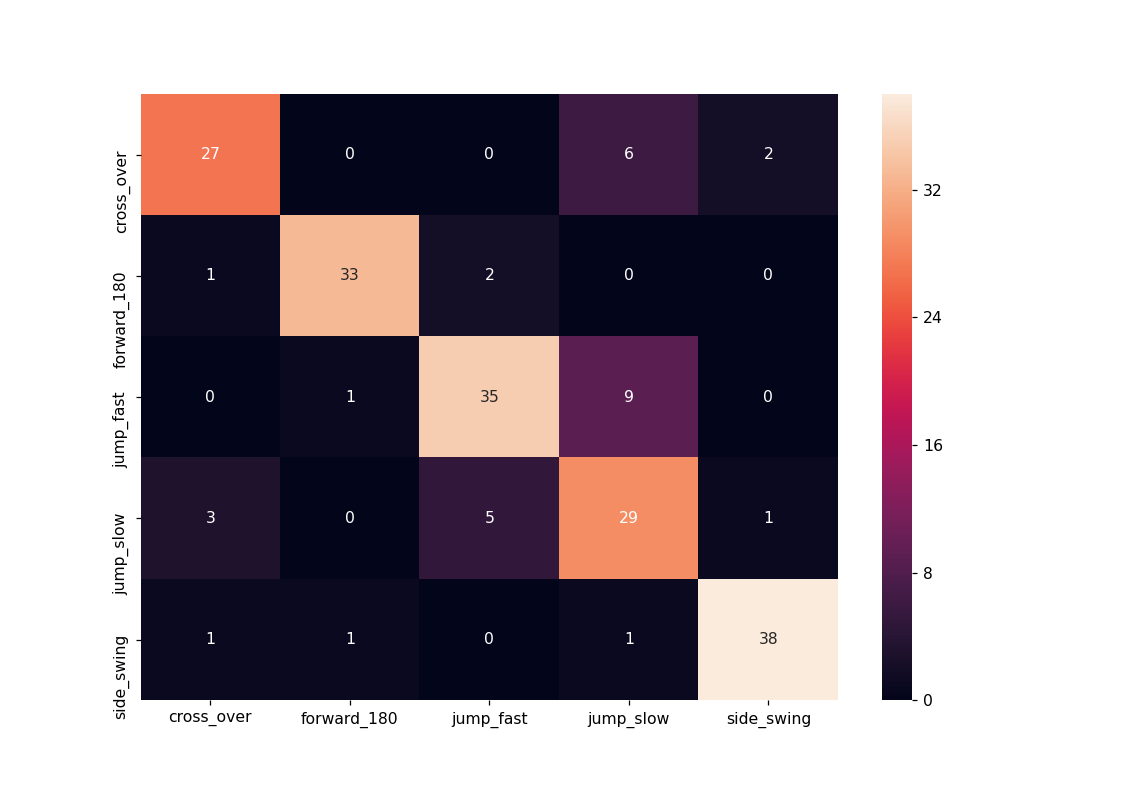

In [52]:
#hyperparameter tuning
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['linear','rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit=True) #verbose=2
grid.fit(X_train,y_train)

clf = grid.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Training set score: {:.3f}".format(clf.score(X_train,y_train)))
print("Test set score: {:.3f}".format(clf.score(X_test,y_test)))
cm = confusion_matrix(y_test, y_pred)

heatmap(cm, labels)

Training set score: 0.881
Test set score: 0.831


<IPython.core.display.Javascript object>


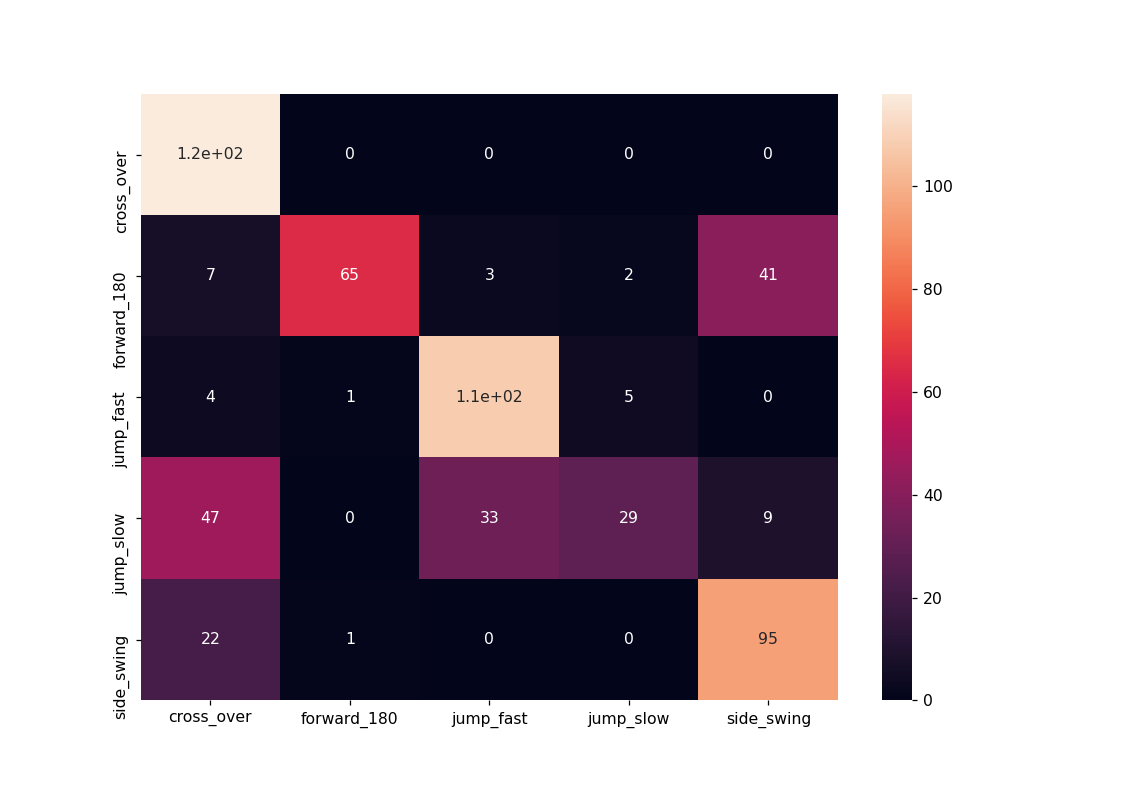

In [53]:
y_pred = clf.predict(merged.drop('activity', axis=1).to_numpy())
cm = confusion_matrix( merged['activity'].to_numpy(), y_pred)
print("Training set score: {:.3f}".format(clf.score(X_train,y_train)))
print("Test set score: {:.3f}".format(clf.score(X_test,y_test)))

heatmap(cm, labels)

## linear SVC

Training set score: 0.911
Test set score: 0.867


<IPython.core.display.Javascript object>


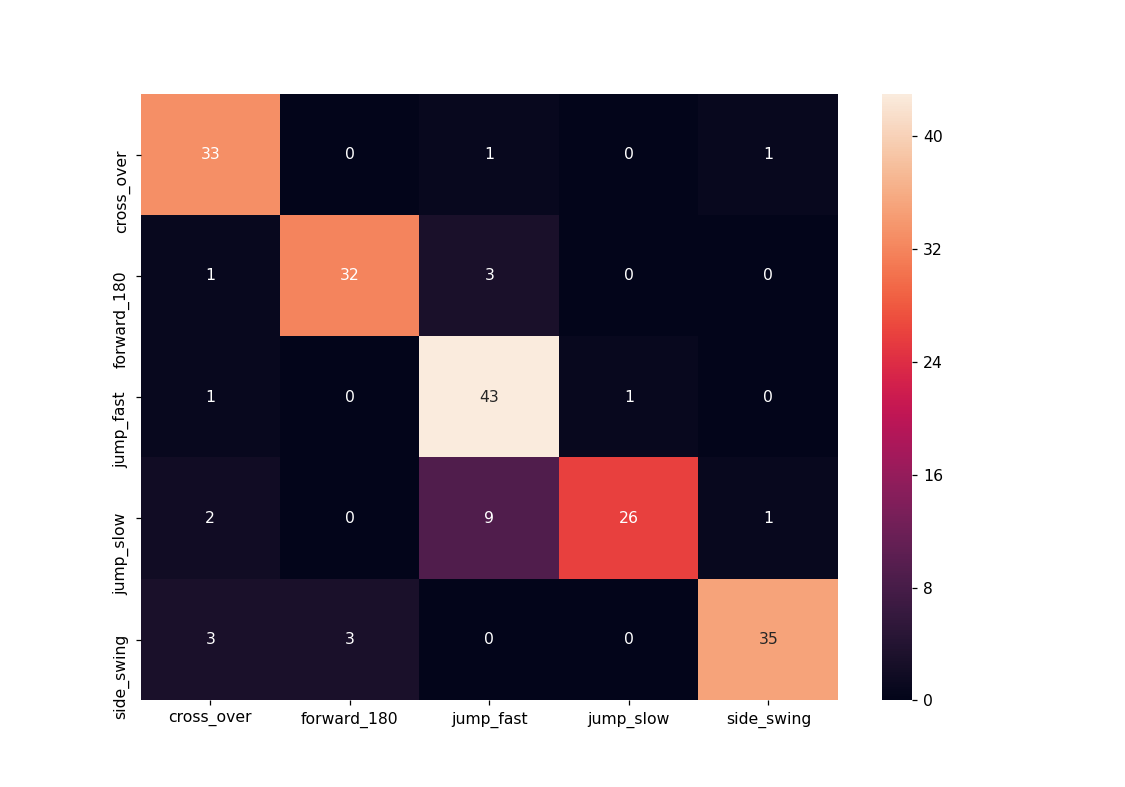

In [54]:
#hyperparameter tuning
param_grid = {'C': [0.1,1, 10, 100]}
grid = GridSearchCV(LinearSVC(),param_grid,refit=True)
grid.fit(X_train,y_train)

clf =  grid.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Training set score: {:.3f}".format(clf.score(X_train,y_train)))
print("Test set score: {:.3f}".format(clf.score(X_test,y_test)))
cm = confusion_matrix(y_test, y_pred)

heatmap(cm,labels)

## random forest

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................. n_estimators=100, total=   0.2s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ................................. n_estimators=100, total=   0.3s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=   0.4s
[CV] n_estimators=1000 ...............................................
[CV] ................................ n_estimators=1000, total=   4.6s
[CV] n_estimators=1000 ...............................................
[CV] ................................ n_estimators=1000, total=   3.7s
[CV] n_estimators=1000 ...............................................
[CV] ................................ n_estimators=1000, total=   4.3s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   13.4s finished


Training set score: 1.000
Test set score: 0.969


<IPython.core.display.Javascript object>


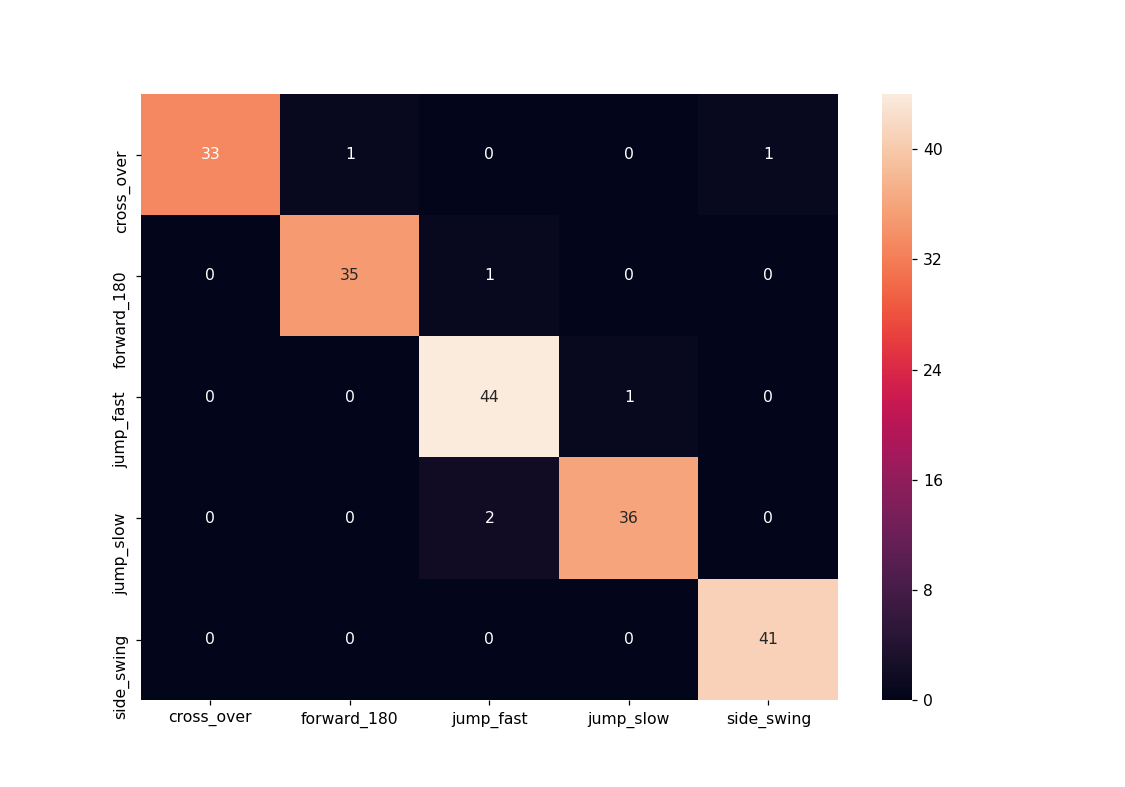

In [55]:
#hyperparameter tuning
param_grid = {'n_estimators': [100, 1000]}
             # 'max_depth': [10, 20],'min_samples_split': np.arange(0.10, 1, 0.4) ,
             # 'max_leaf_nodes': [10, 100, 1000, None]}
grid = GridSearchCV(RandomForestClassifier(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

clf = grid.best_estimator_
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Training set score: {:.3f}".format(clf.score(X_train,y_train)))
print("Test set score: {:.3f}".format(clf.score(X_test,y_test)))
cm = confusion_matrix(y_test, y_pred)

heatmap(cm, labels)

## extra trees classifier

In [ ]:
#hyperparameter tuning
param_grid = {'n_estimators': [10, 100, 1000],
              'max_depth': [1,10,20,30],'min_samples_split': np.arange(0.10, 1, 0.2) ,
                'max_leaf_nodes': [10, 100, 1000, None]}
grid = GridSearchCV(ExtraTreesClassifier(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

clf = grid.best_estimator_
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

heatmap(cm)

## AdaBoost

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), learning_rate=0.1, n_estimators=10 
[CV]  base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='war

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), learning_rate=0.1, n_estimators=50, total=   0.0s
[CV] base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_scor

[CV]  base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), learning_rate=0.30000000000000004, n_estimators=10, total=   0.1s
[CV] base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_job

                       verbose=0, warm_start=False), learning_rate=0.30000000000000004, n_estimators=100, total=   0.0s
[CV] base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), learning_rate=0.30000000000000004, n_estimators=1000 
[CV]  base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_spl

[CV]  base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), learning_rate=0.5000000000000001, n_estimators=50, total=   0.1s
[CV] base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs

[CV]  base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), learning_rate=0.7000000000000001, n_estimators=10, total=   0.1s
[CV] base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs

[CV]  base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), learning_rate=0.7000000000000001, n_estimators=1000, total=   0.0s
[CV] base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jo

[CV]  base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), learning_rate=0.9000000000000001, n_estimators=100, total=   4.4s
[CV] base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_job

[CV]  base_estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators='warn',
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False), learning_rate=0.1, n_estimators=10, total=   0.0s
[CV] base_estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators='warn',
                     n_jobs=None, oob_score=False, random_state=No

[CV]  base_estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators='warn',
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False), learning_rate=0.1, n_estimators=1000, total=   0.0s
[CV] base_estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators='warn',
                     n_jobs=None, oob_score=False, random_state=

[CV]  base_estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators='warn',
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False), learning_rate=0.5000000000000001, n_estimators=10, total=   0.0s
[CV] base_estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators='warn',
                     n_jobs=None, oob_score=False, 

                     warm_start=False), learning_rate=0.7000000000000001, n_estimators=10, total=   0.0s
[CV] base_estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators='warn',
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False), learning_rate=0.7000000000000001, n_estimators=10 
[CV]  base_estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_

                     warm_start=False), learning_rate=0.7000000000000001, n_estimators=1000, total=   0.1s
[CV] base_estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators='warn',
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False), learning_rate=0.7000000000000001, n_estimators=1000 
[CV]  base_estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_wei

[CV]  base_estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators='warn',
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False), learning_rate=0.9000000000000001, n_estimators=1000, total=   0.0s
[CV] base_estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators='warn',
                     n_jobs=None, oob_score=False

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   24.2s finished


<IPython.core.display.Javascript object>


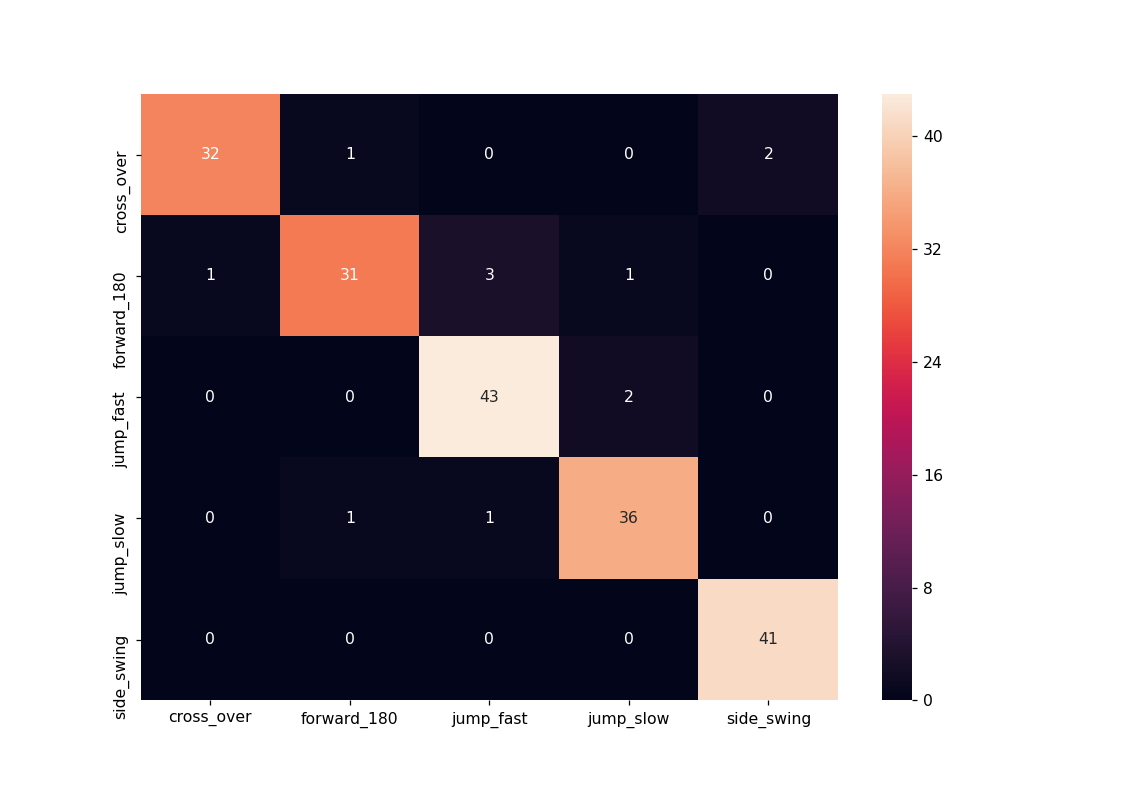

In [57]:
#hyperparameter tuning
param_grid = {'learning_rate': np.arange(0.10, 1, 0.2), 'n_estimators': [10, 50, 100, 1000],
              'base_estimator': [RandomForestClassifier(), ExtraTreesClassifier()]}
             # 'algorithm' : ['SAMME', 'SAMME.R']}
grid = GridSearchCV(AdaBoostClassifier(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

clf = grid.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Training set score: {:.3f}".format(clf.score(X_train,y_train)))
print("Test set score: {:.3f}".format(clf.score(X_test,y_test)))
cm = confusion_matrix(y_test, y_pred)

heatmap(cm, labels)

## naive bayes

Training set score: 1.000
Test set score: 0.938


<IPython.core.display.Javascript object>


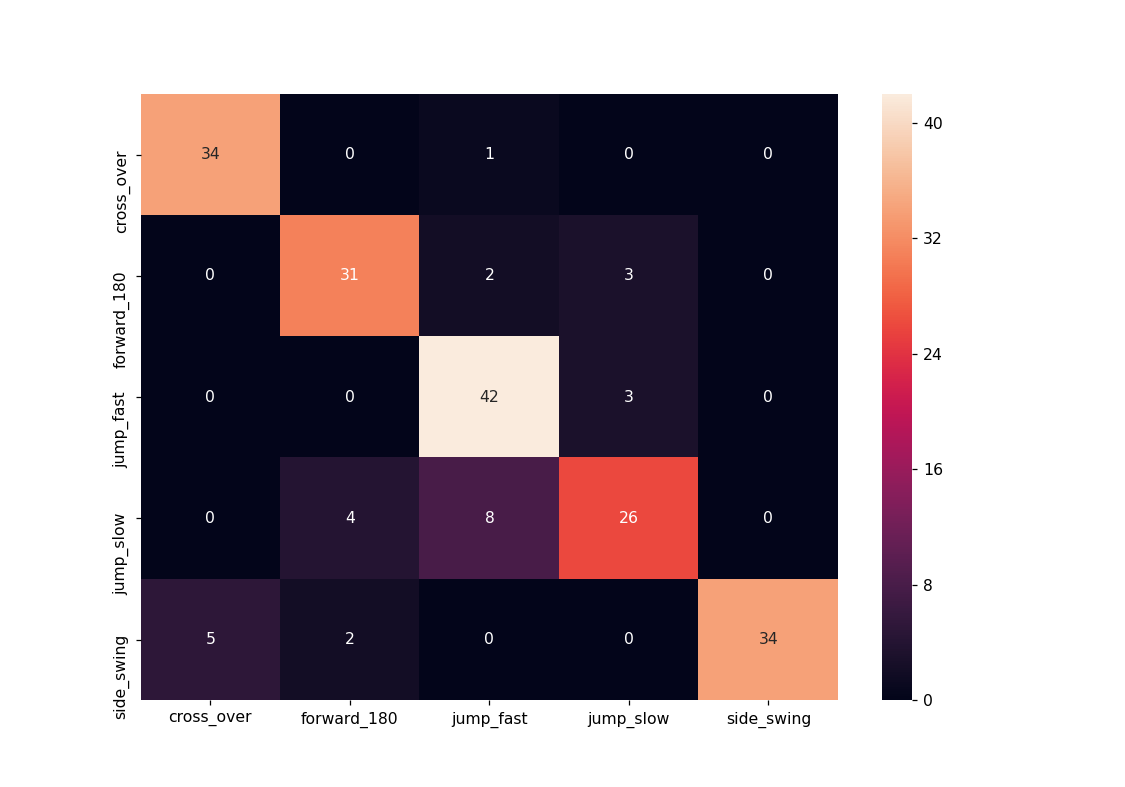

In [58]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print("Training set score: {:.3f}".format(clf.score(X_train,y_train)))
print("Test set score: {:.3f}".format(clf.score(X_test,y_test)))
cm = confusion_matrix(y_test, y_pred)

heatmap(cm, labels)

## kneighbors 

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] algorithm=ball_tree, n_neighbors=1, weights=uniform .............
[CV]  algorithm=ball_tree, n_neighbors=1, weights=uniform, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=1, weights=uniform .............
[CV]  algorithm=ball_tree, n_neighbors=1, weights=uniform, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=1, weights=uniform .............
[CV]  algorithm=ball_tree, n_neighbors=1, weights=uniform, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=1, weights=distance ............
[CV]  algorithm=ball_tree, n_neighbors=1, weights=distance, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=1, weights=distance ............
[CV]  algorithm=ball_tree, n_neighbors=1, weights=distance, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=1, weights=distance ............
[CV]  algorithm=ball_tree, n_neighbors=1, weights=distance, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=2, weights=uniform .............
[

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] algorithm=ball_tree, n_neighbors=4, weights=distance ............
[CV]  algorithm=ball_tree, n_neighbors=4, weights=distance, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=4, weights=distance ............
[CV]  algorithm=ball_tree, n_neighbors=4, weights=distance, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=8, weights=uniform .............
[CV]  algorithm=ball_tree, n_neighbors=8, weights=uniform, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=8, weights=uniform .............
[CV]  algorithm=ball_tree, n_neighbors=8, weights=uniform, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=8, weights=uniform .............
[CV]  algorithm=ball_tree, n_neighbors=8, weights=uniform, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=8, weights=distance ............
[CV]  algorithm=ball_tree, n_neighbors=8, weights=distance, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=8, weights=distance ............
[CV]  algorithm=ball_tree, n_neighbors=8, weights=distance, t

[CV] .. algorithm=brute, n_neighbors=4, weights=uniform, total=   0.0s
[CV] algorithm=brute, n_neighbors=4, weights=distance ................
[CV] . algorithm=brute, n_neighbors=4, weights=distance, total=   0.0s
[CV] algorithm=brute, n_neighbors=4, weights=distance ................
[CV] . algorithm=brute, n_neighbors=4, weights=distance, total=   0.0s
[CV] algorithm=brute, n_neighbors=4, weights=distance ................
[CV] . algorithm=brute, n_neighbors=4, weights=distance, total=   0.0s
[CV] algorithm=brute, n_neighbors=8, weights=uniform .................
[CV] .. algorithm=brute, n_neighbors=8, weights=uniform, total=   0.0s
[CV] algorithm=brute, n_neighbors=8, weights=uniform .................
[CV] .. algorithm=brute, n_neighbors=8, weights=uniform, total=   0.0s
[CV] algorithm=brute, n_neighbors=8, weights=uniform .................
[CV] .. algorithm=brute, n_neighbors=8, weights=uniform, total=   0.0s
[CV] algorithm=brute, n_neighbors=8, weights=distance ................
[CV] .

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.8s finished


<IPython.core.display.Javascript object>


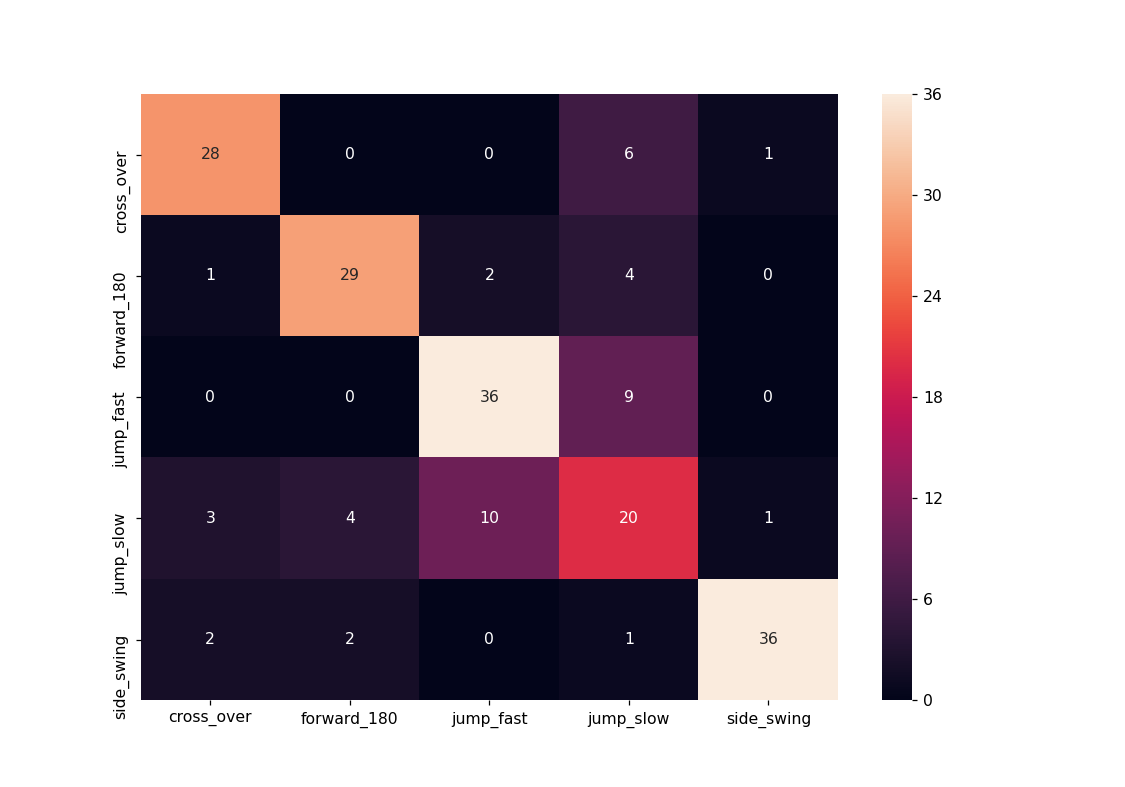

In [59]:
#hyperparameter tuning
param_grid = {'n_neighbors': [1,2,4,8,10], 'weights': ['uniform', 'distance'],
              'algorithm': ['ball_tree', 'kd_tree', 'brute']}#, 'leaf_size': range(1,60,10), 
            #  'metric' : ['minkowski']}
grid = GridSearchCV(KNeighborsClassifier(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

clf = grid.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Training set score: {:.3f}".format(clf.score(X_train,y_train)))
print("Test set score: {:.3f}".format(clf.score(X_test,y_test)))
cm = confusion_matrix(y_test, y_pred)

heatmap(cm, labels)

## SGD classifier

Fitting 3 folds for each of 84 candidates, totalling 252 fits
[CV] alpha=1e-07, eta0=1, learning_rate=constant, max_iter=10, shuffle=True 
[CV]  alpha=1e-07, eta0=1, learning_rate=constant, max_iter=10, shuffle=True, total=   0.0s
[CV] alpha=1e-07, eta0=1, learning_rate=constant, max_iter=10, shuffle=True 
[CV]  alpha=1e-07, eta0=1, learning_rate=constant, max_iter=10, shuffle=True, total=   0.0s
[CV] alpha=1e-07, eta0=1, learning_rate=constant, max_iter=10, shuffle=True 
[CV]  alpha=1e-07, eta0=1, learning_rate=constant, max_iter=10, shuffle=True, total=   0.0s
[CV] alpha=1e-07, eta0=1, learning_rate=constant, max_iter=100, shuffle=True 
[CV]  alpha=1e-07, eta0=1, learning_rate=constant, max_iter=100, shuffle=True, total=   0.0s
[CV] alpha=1e-07, eta0=1, learning_rate=constant, max_iter=100, shuffle=True 
[CV]  alpha=1e-07, eta0=1, learning_rate=constant, max_iter=100, shuffle=True, total=   0.0s
[CV] alpha=1e-07, eta0=1, learning_rate=constant, max_iter=100, shuffle=True 
[CV]  alpha

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] alpha=1e-07, eta0=1, learning_rate=optimal, max_iter=1000, shuffle=True 
[CV]  alpha=1e-07, eta0=1, learning_rate=optimal, max_iter=1000, shuffle=True, total=   0.0s
[CV] alpha=1e-07, eta0=1, learning_rate=optimal, max_iter=1000, shuffle=True 
[CV]  alpha=1e-07, eta0=1, learning_rate=optimal, max_iter=1000, shuffle=True, total=   0.0s
[CV] alpha=1e-07, eta0=1, learning_rate=optimal, max_iter=1000, shuffle=True 
[CV]  alpha=1e-07, eta0=1, learning_rate=optimal, max_iter=1000, shuffle=True, total=   0.0s
[CV] alpha=1e-07, eta0=1, learning_rate=invscaling, max_iter=10, shuffle=True 
[CV]  alpha=1e-07, eta0=1, learning_rate=invscaling, max_iter=10, shuffle=True, total=   0.0s
[CV] alpha=1e-07, eta0=1, learning_rate=invscaling, max_iter=10, shuffle=True 
[CV]  alpha=1e-07, eta0=1, learning_rate=invscaling, max_iter=10, shuffle=True, total=   0.0s
[CV] alpha=1e-07, eta0=1, learning_rate=invscaling, max_iter=10, shuffle=True 
[CV]  alpha=1e-07, eta0=1, learning_rate=invscaling, max_iter

[CV]  alpha=1e-06, eta0=1, learning_rate=adaptive, max_iter=10, shuffle=True, total=   0.0s
[CV] alpha=1e-06, eta0=1, learning_rate=adaptive, max_iter=10, shuffle=True 
[CV]  alpha=1e-06, eta0=1, learning_rate=adaptive, max_iter=10, shuffle=True, total=   0.0s
[CV] alpha=1e-06, eta0=1, learning_rate=adaptive, max_iter=100, shuffle=True 
[CV]  alpha=1e-06, eta0=1, learning_rate=adaptive, max_iter=100, shuffle=True, total=   0.0s
[CV] alpha=1e-06, eta0=1, learning_rate=adaptive, max_iter=100, shuffle=True 
[CV]  alpha=1e-06, eta0=1, learning_rate=adaptive, max_iter=100, shuffle=True, total=   0.0s
[CV] alpha=1e-06, eta0=1, learning_rate=adaptive, max_iter=100, shuffle=True 
[CV]  alpha=1e-06, eta0=1, learning_rate=adaptive, max_iter=100, shuffle=True, total=   0.0s
[CV] alpha=1e-06, eta0=1, learning_rate=adaptive, max_iter=1000, shuffle=True 
[CV]  alpha=1e-06, eta0=1, learning_rate=adaptive, max_iter=1000, shuffle=True, total=   0.0s
[CV] alpha=1e-06, eta0=1, learning_rate=adaptive, max

[CV] alpha=0.0001, eta0=1, learning_rate=invscaling, max_iter=10, shuffle=True 
[CV]  alpha=0.0001, eta0=1, learning_rate=invscaling, max_iter=10, shuffle=True, total=   0.0s
[CV] alpha=0.0001, eta0=1, learning_rate=invscaling, max_iter=10, shuffle=True 
[CV]  alpha=0.0001, eta0=1, learning_rate=invscaling, max_iter=10, shuffle=True, total=   0.0s
[CV] alpha=0.0001, eta0=1, learning_rate=invscaling, max_iter=100, shuffle=True 
[CV]  alpha=0.0001, eta0=1, learning_rate=invscaling, max_iter=100, shuffle=True, total=   0.0s
[CV] alpha=0.0001, eta0=1, learning_rate=invscaling, max_iter=100, shuffle=True 
[CV]  alpha=0.0001, eta0=1, learning_rate=invscaling, max_iter=100, shuffle=True, total=   0.1s
[CV] alpha=0.0001, eta0=1, learning_rate=invscaling, max_iter=100, shuffle=True 
[CV]  alpha=0.0001, eta0=1, learning_rate=invscaling, max_iter=100, shuffle=True, total=   0.0s
[CV] alpha=0.0001, eta0=1, learning_rate=invscaling, max_iter=1000, shuffle=True 
[CV]  alpha=0.0001, eta0=1, learning_

[CV]  alpha=0.1, eta0=1, learning_rate=optimal, max_iter=100, shuffle=True, total=   0.0s
[CV] alpha=0.1, eta0=1, learning_rate=optimal, max_iter=100, shuffle=True 
[CV]  alpha=0.1, eta0=1, learning_rate=optimal, max_iter=100, shuffle=True, total=   0.0s
[CV] alpha=0.1, eta0=1, learning_rate=optimal, max_iter=100, shuffle=True 
[CV]  alpha=0.1, eta0=1, learning_rate=optimal, max_iter=100, shuffle=True, total=   0.0s
[CV] alpha=0.1, eta0=1, learning_rate=optimal, max_iter=1000, shuffle=True 
[CV]  alpha=0.1, eta0=1, learning_rate=optimal, max_iter=1000, shuffle=True, total=   0.0s
[CV] alpha=0.1, eta0=1, learning_rate=optimal, max_iter=1000, shuffle=True 
[CV]  alpha=0.1, eta0=1, learning_rate=optimal, max_iter=1000, shuffle=True, total=   0.0s
[CV] alpha=0.1, eta0=1, learning_rate=optimal, max_iter=1000, shuffle=True 
[CV]  alpha=0.1, eta0=1, learning_rate=optimal, max_iter=1000, shuffle=True, total=   0.0s
[CV] alpha=0.1, eta0=1, learning_rate=invscaling, max_iter=10, shuffle=True 
[C

[Parallel(n_jobs=1)]: Done 252 out of 252 | elapsed:    4.3s finished


<IPython.core.display.Javascript object>


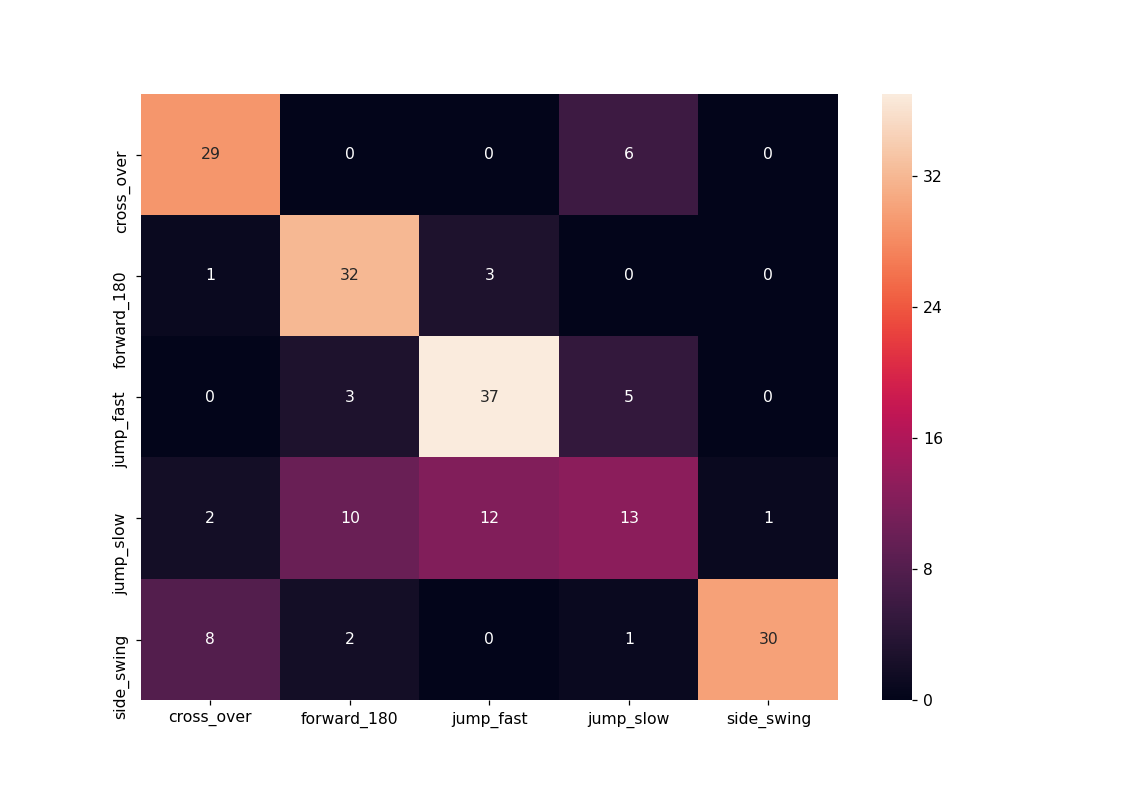

In [63]:
#hyperparameter tuning
param_grid = {'alpha': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], 'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'], 
              'max_iter': [10, 100, 1000], #np.ceil(10**6 / n) 
             'shuffle' : [True], 'eta0' : [1]}
grid = GridSearchCV(SGDClassifier(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

clf = grid.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Training set score: {:.3f}".format(clf.score(X_train,y_train)))
print("Test set score: {:.3f}".format(clf.score(X_test,y_test)))
cm = confusion_matrix(y_test, y_pred)

heatmap(cm,labels)

## MLP classifier

Training set score: 0.754
Test set score: 0.785


<IPython.core.display.Javascript object>


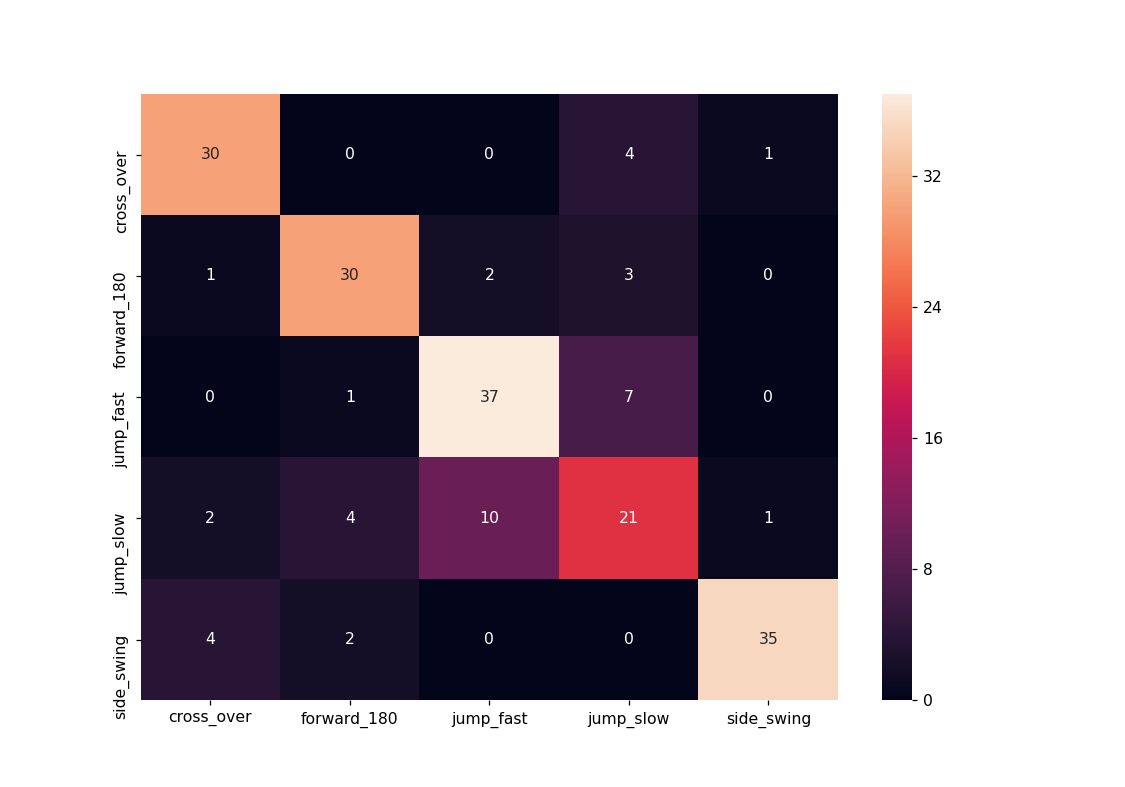

In [66]:
#hyperparameter tuning
#param_grid = {'solver': ['lbfgs', 'sgd', 'adam'], 'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], 
   # 'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)], #'activation': ['identity', 'logistic','tanh', 'relu'],
    #'learning_rate': ['invscaling', 'constant','adaptive']}
#grid = GridSearchCV(MLPClassifier(),param_grid,refit=True,verbose=2)
#grid.fit(X_train,y_train)

#clf = grid.best_estimator_
clf=MLPClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Training set score: {:.3f}".format(clf.score(X_train,y_train)))
print("Test set score: {:.3f}".format(clf.score(X_test,y_test)))
cm = confusion_matrix(y_test, y_pred)

heatmap(cm, labels)

# save model

In [53]:
filename = 'rope_skipping_model.sav'
joblib.dump(clf, filename)

['rope_skipping_model.sav']

In [54]:
filename = 'rope_skipping_label_encoder.plk'
joblib.dump(le, filename)

['rope_skipping_label_encoder.plk']

In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
new_model = tf.keras.models.load_model('rope_skipping_cnn')

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 1, 16)         160       
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 1, 16)         64        
_________________________________________________________________
dropout (Dropout)            (None, 50, 1, 16)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 1, 32)         544       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 1, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                1